# Random Forest


- What is this notebook for? 
  - Notebook that runs the baseline model of the project
  - Machine Learning Algorithms : Random Forest
  - Metrics: F1, accuracy, precision

RF in spark

https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#notebook/1898361324232092/command/1898361324232093

Feature selection in RF

https://antonhaugen.medium.com/feature-selection-for-pyspark-tree-classifiers-3be54a8bc493

# 0. Preparation

In [0]:
from pyspark.sql.functions import col
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.functions import col
import pandas as pd
import numpy as np
import os

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from pyspark.sql.functions import desc

import geopandas as gpd
import folium

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import MinMaxScaler
from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from pyspark.ml.classification import RandomForestClassifier
import time


In [0]:
# Put at the top of any notebooks for storing in blob

from pyspark.sql.functions import col, max

blob_container = "team06" # The name of your container created in https://portal.azure.com
storage_account = "apatel" # The name of your Storage account created in https://portal.azure.com
secret_scope = "team06" # The name of the scope created in your local computer using the Databricks CLI
secret_key = "team06" # The name of the secret key created in your local computer using the Databricks CLI 
blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"
mount_path = "/mnt/mids-w261"

## Import weather + station + 6 months airline data

In [0]:
df_5yr_join = spark.read.parquet(f'{blob_url}/full_join_mattsFeats_anandFeats_cleaned_v2')

In [0]:
# copied from section `Flights Features to Keep`
Features_for_flights=[ 'DISTANCE','ORI_elevation','DEST_elevation', 
                   'prior_dep_delayed', 'previous_DEP_DELAY_NEW',
                    'prior_arr_delayed', 'previous_ARR_DELAY_NEW', 'plane_is_here',
                    'avg_carrier_delay_24hrs', 'flights_sch_Today_ORIGIN', 'flights_sch_Today_DEST', 'avg_ori_airport_delay_24hrs',
                    'late_night', 'daytime', 'evening',
                    'new_england', 'mid_atlantic', 'south', 'midwest', 'southwest', 'west', 'pacific_islands', 'atlantic_islands',
                    'spring', 'summer', 'winter', 'autumn',
                    'weekend_or_holiday'
                   ]

# specify any outcome variables you also want to check for missing
Outcomes_for_flights=[ 'DEP_DEL15', 'DEP_DELAY_NEW']

# combine:
cols_to_check = Outcomes_for_flights + Features_for_flights

print(cols_to_check)

['DEP_DEL15', 'DEP_DELAY_NEW', 'DISTANCE', 'ORI_elevation', 'DEST_elevation', 'prior_dep_delayed', 'previous_DEP_DELAY_NEW', 'prior_arr_delayed', 'previous_ARR_DELAY_NEW', 'plane_is_here', 'avg_carrier_delay_24hrs', 'flights_sch_Today_ORIGIN', 'flights_sch_Today_DEST', 'avg_ori_airport_delay_24hrs', 'late_night', 'daytime', 'evening', 'new_england', 'mid_atlantic', 'south', 'midwest', 'southwest', 'west', 'pacific_islands', 'atlantic_islands', 'spring', 'summer', 'winter', 'autumn', 'weekend_or_holiday']

In [0]:
Features_for_cv_unwrap = ['CRS_DEP_DATETIME_UTC_END']+['ORI_station_id']+ Outcomes_for_flights + Features_for_flights + ['WND']

In [0]:
display(df_5yr_join)

YEAR QUARTER MONTH DAY_OF_MONTH DAY_OF_WEEK FL_DATE OP_UNIQUE_CARRIER OP_CARRIER_AIRLINE_ID TAIL_NUM OP_CARRIER_FL_NUM ORIGIN_AIRPORT_ID ORIGIN_AIRPORT_SEQ_ID ORIGIN ORIGIN_STATE_ABR ORIGIN_STATE_FIPS ORIGIN_STATE_NM DEST_AIRPORT_ID DEST_AIRPORT_SEQ_ID DEST DEST_STATE_ABR DEST_STATE_FIPS DEST_STATE_NM CRS_DEP_TIME DEP_TIME DEP_DELAY DEP_DELAY_NEW DEP_DEL15 DEP_DELAY_GROUP DEP_TIME_BLK CRS_ARR_TIME ARR_TIME ARR_DELAY ARR_DELAY_NEW ARR_DEL15 CANCELLED ACTUAL_ELAPSED_TIME DISTANCE DISTANCE_GROUP CARRIER_DELAY WEATHER_DELAY NAS_DELAY LATE_AIRCRAFT_DELAY ORI_IATA ORI_station_id ORI_station_lat ORI_station_lon ORI_airport_lat ORI_airport_lon ORI_elevation ORI_dist_airp_sta DEST_IATA DEST_station_id DEST_station_lat DEST_station_lon DEST_airport_lat DEST_airport_lon DEST_elevation DEST_dist_airp_sta CRS_DEP_HRS CRS_DEP_MINS CRS_DEP_TIME_STR CRS_DEP_DT_STR CRS_DEP_DATETIME iata_code ORI_timezone CRS_DEP_DATETIME_UTC CRS_DEP_DATETIME_UTC_END CRS_DEP_DATETIME_UTC_START STATION DATE LATITUDE LONGITUDE ELEVATION REPORT_TYPE WND CIG VIS TMP DEW SLP AW1 MA1 MW1 MW2 OC1 AW2 GD1 AJ1 AW3 MW5 AA3 AU2 AA1 WA1 AI1 MW4 MV1 MW3 DEST_timezone DEP_HRS DEP_MINS DEP_TIME_STR DEP_DT_STR DEP_DATETIME ARR_DATETIME_ACTUAL_UTC late_night daytime evening region_name new_england mid_atlantic south midwest southwest west pacific_islands atlantic_islands spring summer autumn winter dep_date weekend_or_holiday flightID ID previous_flight_delay_status previous_flight_dep_time time_between_departures_min valid_dep_delay prior_dep_delayed previous_DEP_DELAY_NEW_value previous_DEP_DELAY_NEW previous_flight_arrdelay_status previous_flight_arr_time time_between_arrival_and_end_min valid_arr_delay prior_arr_delayed previous_ARR_DELAY_NEW_value previous_ARR_DELAY_NEW prev_arrival_airport plane_is_here avg_carrier_delay_24hrs flights_sch_Today_ORIGIN flights_sch_Today_DEST avg_ori_airport_delay_24hrs year_quarter quarter_enum quarter_enum_prev 2018 1 1 1 1 2018-01-01 G4 20368 232NV 817 12223 1222305 HTS WV 54 West Virginia 14112 1411206 PIE FL 12 Florida 1434 1427 -7.0 0.0 0.0 -1 1400-1459 1635 1627 -8.0 0.0 0.0 0.0 120.0 721.0 3 null null null null HTS 72425003860 38.365 -82.555 38.36669922 -82.55799866 828.0 0.3225655701525514 PIE 72211612873 27.911 -82.688 27.91020012 -82.68740082 11.0 0.10666385498371135 14 34 14:34 2018-01-01 14:34 2018-01-01T14:34:00.000+0000 HTS America/New_York 2018-01-01T19:34:00.000+0000 2018-01-01T17:34:00.000+0000 2018-01-01T15:34:00.000+0000 72425003860 2018-01-01T16:51:00.000+0000 38.36532 -82.55485 251.2 FM-15 250,5,N,0036,5 00366,5,M,N 008047,5,N,5 -0117,5 -0156,5 10387,5 71,5 10373,5,10064,5 4,99,1,+00366,5,9 01,0000,2,5 America/New_York 14 27 14:27 2018-01-01 14:27 2018-01-01T14:27:00.000+0000 2018-01-01T21:27:00.000+0000 0 0 1 south 0 0 1 0 0 0 0 0 0 0 0 1 2018-01-01 1 154618831175 G4232NVHTS2018-01-011434 0.0 2018-01-01T16:48:00.000+0000 166.0 yes 0 0.0 0.0 0.0 2018-01-01T18:36:00.000+0000 58.0 no 0 0.0 0.0 HTS 0 0.22 2 27 0.13 2018-1 12 11 2018 1 1 1 1 2018-01-01 G4 20368 412NV 633 12223 1222305 HTS WV 54 West Virginia 14761 1476106 SFB FL 12 Florida 1619 1633 14.0 14.0 0.0 0 1600-1659 1811 1819 8.0 8.0 0.0 0.0 106.0 665.0 3 null null null null HTS 72425003860 38.365 -82.555 38.36669922 -82.55799866 828.0 0.3225655701525514 SFB 72205712854 28.78 -81.244 28.77759933 -81.23750305 55.0 0.6871667327531956 16 19 16:19 2018-01-01 16:19 2018-01-01T16:19:00.000+0000 HTS America/New_York 2018-01-01T21:19:00.000+0000 2018-01-01T19:19:00.000+0000 2018-01-01T17:19:00.000+0000 72425003860 2018-01-01T18:51:00.000+0000 38.36532 -82.55485 251.2 FM-15 290,5,N,0031,5 22000,5,9,N 016093,5,N,5 -0089,5 -0156,5 10371,5 10356,5,10047,5 1,99,1,+00732,5,9 01,0000,2,5 America/New_York 16 33 16:33 2018-01-01 16:33 2018-01-01T16:33:00.000+0000 2018-01-01T23:19:00.000+0000 0 0 1 south 0 0 1 0 0 0 0 0 0 0 0 1 2018-01-01 1 197569301006 G4412NVHTS2018-01-011619 1.0 2018-01-01T18:39:00.000+0000 160.0 yes 1 22.0 22.0 1.0 2018-01-01T20:51:00.000+0000 28.0 no 0 17.0 0.

## Select features for CV split and modeling
Note for teams:
- `MONTH` or `DAY_OF_WEEK` to be deleted later(assumed to use but finally not)

In [0]:
df_5yr_join_XY = df_5yr_join.select(['CRS_DEP_DATETIME_UTC_END']+['ORI_station_id']+ Outcomes_for_flights + Features_for_flights + ['WND'])

In [0]:
display(df_5yr_join_XY)

CRS_DEP_DATETIME_UTC_END ORI_station_id DEP_DEL15 DEP_DELAY_NEW DISTANCE ORI_elevation DEST_elevation prior_dep_delayed previous_DEP_DELAY_NEW prior_arr_delayed previous_ARR_DELAY_NEW plane_is_here avg_carrier_delay_24hrs flights_sch_Today_ORIGIN flights_sch_Today_DEST avg_ori_airport_delay_24hrs late_night daytime evening new_england mid_atlantic south midwest southwest west pacific_islands atlantic_islands spring summer winter autumn weekend_or_holiday WND 2018-01-01T17:34:00.000+0000 72425003860 0.0 0.0 721.0 828.0 11.0 0 0.0 0 0.0 0 0.22 2 27 0.13 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 250,5,N,0036,5 2018-01-01T19:19:00.000+0000 72425003860 0.0 14.0 665.0 828.0 55.0 1 22.0 0 0.0 0 0.26 2 21 0.13 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 290,5,N,0031,5 2018-01-02T13:46:00.000+0000 72425003860 1.0 24.0 665.0 828.0 55.0 0 4.0 0 0.0 0 0.35 2 40 0.0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 210,5,N,0021,5 2018-01-02T19:03:00.000+0000 72425003860 1.0 24.0 721.0 828.0 11.0 1 19.0 0 0.0 0 0.39 2 24 0.33 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 999,9,C,0000,5 2018-01-03T14:16:00.000+0000 72425003860 1.0 44.0 665.0 828.0 55.0 0 10.0 0 0.0 0 0.44 1 19 1.0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 999,9,C,0000,5 2018-01-05T14:08:00.000+0000 72425003860 1.0 30.0 665.0 828.0 55.0 1 23.0 0 0.0 0 0.29 2 32 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 999,9,V,0031,5 2018-01-05T17:37:00.000+0000 72425003860 1.0 51.0 721.0 828.0 11.0 1 39.0 0 0.0 0 0.28 2 20 1.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 270,5,N,0041,5 2018-01-08T12:38:00.000+0000 72425003860 0.0 0.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.24 2 34 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 200,1,N,0026,1 2018-01-08T17:37:00.000+0000 72425003860 0.0 0.0 721.0 828.0 11.0 0 0.0 0 0.0 0 0.23 2 22 0.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 230,5,N,0021,5 2018-01-10T12:53:00.000+0000 72425003860 0.0 0.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.11 1 16 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 030,5,N,0015,5 2018-01-12T14:08:00.000+0000 72425003860 0.0 0.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.18 2 31 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 160,5,N,0015,5 2018-01-12T17:37:00.000+0000 72425003860 1.0 18.0 721.0 828.0 11.0 1 16.0 0 0.0 0 0.19 2 23 0.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 330,5,N,0021,5 2018-01-15T14:08:00.000+0000 72425003860 1.0 97.0 665.0 828.0 55.0 1 97.0 0 0.0 0 0.2 2 32 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 130,5,N,0015,5 2018-01-15T17:37:00.000+0000 72425003860 1.0 114.0 721.0 828.0 11.0 1 114.0 0 0.0 0 0.22 2 22 1.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 210,5,N,0021,5 2018-01-17T12:53:00.000+0000 72425003860 0.0 0.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.18 1 16 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 210,5,N,0015,5 2018-01-19T14:08:00.000+0000 72425003860 1.0 26.0 665.0 828.0 55.0 1 35.0 0 0.0 0 0.18 2 33 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 200,5,N,0036,5 2018-01-19T17:37:00.000+0000 72425003860 0.0 5.0 721.0 828.0 11.0 0 0.0 0 0.0 0 0.16 2 22 1.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 200,5,N,0026,5 2018-01-22T14:08:00.000+0000 72425003860 0.0 0.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.13 2 33 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 130,5,N,0031,5 2018-01-22T17:37:00.000+0000 72425003860 0.0 0.0 721.0 828.0 11.0 0 0.0 0 0.0 0 0.15 2 23 0.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 170,5,N,0046,5 2018-01-24T12:54:00.000+0000 72425003860 0.0 0.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.05 1 16 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 290,5,N,0021,5 2018-01-26T14:08:00.000+0000 72425003860 0.0 9.0 665.0 828.0 55.0 1 15.0 0 0.0 0 0.19 2 33 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 999,9,C,0000,5 2018-01-26T17:37:00.000+0000 72425003860 0.0 0.0 721.0 828.0 11.0 0 0.0 0 0.0 0 0.16 2 22 0.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 190,5,N,0046,5 2018-01-29T14:08:00.000+0000 72425003860 1.0 409.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.12 2 33 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 999,9,C,0000,5 2018-01-29T17:37:00.000+0000 72425003860 0.0 5.0 721.0 828.0 11.0 0 0.0 0 0.0 0 0.13 2 22 1.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 999,9,V,0015,5 2018-01-31T12:59:00.000+0000 72425003860 0.0 0.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.15 1 17 0.13 0 1 0 0 0 1 0 0 0 0 0

#### Processing Wind for Baseline (Optional)
Process wind column WND to make a simple weather column for the baseline. Once our weather features and processed and included into our loaded in data, this is redundant.

In [0]:
#udf in Pyspark
# Type in Spark 'BinaryType', 'BooleanType', 'ByteType', 'DateType', 'DecimalType', 'DoubleType', 'FloatType', 'IntegerType', 'LongType', 'ShortType', 'StringType', 'TimestampType']:

from pyspark.sql.functions import udf,col
from pyspark.sql.types import StringType, DoubleType, IntegerType

# define function
# Below are the functions that unwraps a cell with five components
def unwrap5Comp0(x):
  return x.split(',')[0]
def unwrap5Comp1(x):
  return x.split(',')[1]
def unwrap5Comp2(x):
  return x.split(',')[2]
def unwrap5Comp3(x):
  return x.split(',')[3]
def unwrap5Comp4(x):
  return x.split(',')[4]

# add column
udf_unwrap5Comp0 = udf(lambda x:int(unwrap5Comp0(x)),IntegerType() )
udf_unwrap5Comp1 = udf(lambda x:unwrap5Comp1(x),StringType() )
udf_unwrap5Comp2 = udf(lambda x:unwrap5Comp2(x),StringType() )
udf_unwrap5Comp3 = udf(lambda x:int(unwrap5Comp3(x)),IntegerType() )
udf_unwrap5Comp4 = udf(lambda x:unwrap5Comp4(x),StringType() )

df_5yr_join_XY_WND = df_5yr_join_XY.withColumn('WND_0',udf_unwrap5Comp0(df_5yr_join_XY['WND']))\
                                   .withColumn('WND_1',udf_unwrap5Comp1(df_5yr_join_XY['WND']))\
                                   .withColumn('WND_2',udf_unwrap5Comp2(df_5yr_join_XY['WND']))\
                                   .withColumn('WND_3',udf_unwrap5Comp3(df_5yr_join_XY['WND']))\
                                   .withColumn('WND_4',udf_unwrap5Comp4(df_5yr_join_XY['WND']))

In [0]:
display(df_5yr_join_XY_WND)

CRS_DEP_DATETIME_UTC_END ORI_station_id DEP_DEL15 DEP_DELAY_NEW DISTANCE ORI_elevation DEST_elevation prior_dep_delayed previous_DEP_DELAY_NEW prior_arr_delayed previous_ARR_DELAY_NEW plane_is_here avg_carrier_delay_24hrs flights_sch_Today_ORIGIN flights_sch_Today_DEST avg_ori_airport_delay_24hrs late_night daytime evening new_england mid_atlantic south midwest southwest west pacific_islands atlantic_islands spring summer winter autumn weekend_or_holiday WND WND_0 WND_1 WND_2 WND_3 WND_4 2018-01-01T17:34:00.000+0000 72425003860 0.0 0.0 721.0 828.0 11.0 0 0.0 0 0.0 0 0.22 2 27 0.13 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 250,5,N,0036,5 250 5 N 36 5 2018-01-01T19:19:00.000+0000 72425003860 0.0 14.0 665.0 828.0 55.0 1 22.0 0 0.0 0 0.26 2 21 0.13 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 290,5,N,0031,5 290 5 N 31 5 2018-01-02T13:46:00.000+0000 72425003860 1.0 24.0 665.0 828.0 55.0 0 4.0 0 0.0 0 0.35 2 40 0.0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 210,5,N,0021,5 210 5 N 21 5 2018-01-02T19:03:00.000+0000 72425003860 1.0 24.0 721.0 828.0 11.0 1 19.0 0 0.0 0 0.39 2 24 0.33 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 999,9,C,0000,5 999 9 C 0 5 2018-01-03T14:16:00.000+0000 72425003860 1.0 44.0 665.0 828.0 55.0 0 10.0 0 0.0 0 0.44 1 19 1.0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 999,9,C,0000,5 999 9 C 0 5 2018-01-05T14:08:00.000+0000 72425003860 1.0 30.0 665.0 828.0 55.0 1 23.0 0 0.0 0 0.29 2 32 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 999,9,V,0031,5 999 9 V 31 5 2018-01-05T17:37:00.000+0000 72425003860 1.0 51.0 721.0 828.0 11.0 1 39.0 0 0.0 0 0.28 2 20 1.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 270,5,N,0041,5 270 5 N 41 5 2018-01-08T12:38:00.000+0000 72425003860 0.0 0.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.24 2 34 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 200,1,N,0026,1 200 1 N 26 1 2018-01-08T17:37:00.000+0000 72425003860 0.0 0.0 721.0 828.0 11.0 0 0.0 0 0.0 0 0.23 2 22 0.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 230,5,N,0021,5 230 5 N 21 5 2018-01-10T12:53:00.000+0000 72425003860 0.0 0.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.11 1 16 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 030,5,N,0015,5 30 5 N 15 5 2018-01-12T14:08:00.000+0000 72425003860 0.0 0.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.18 2 31 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 160,5,N,0015,5 160 5 N 15 5 2018-01-12T17:37:00.000+0000 72425003860 1.0 18.0 721.0 828.0 11.0 1 16.0 0 0.0 0 0.19 2 23 0.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 330,5,N,0021,5 330 5 N 21 5 2018-01-15T14:08:00.000+0000 72425003860 1.0 97.0 665.0 828.0 55.0 1 97.0 0 0.0 0 0.2 2 32 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 130,5,N,0015,5 130 5 N 15 5 2018-01-15T17:37:00.000+0000 72425003860 1.0 114.0 721.0 828.0 11.0 1 114.0 0 0.0 0 0.22 2 22 1.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 210,5,N,0021,5 210 5 N 21 5 2018-01-17T12:53:00.000+0000 72425003860 0.0 0.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.18 1 16 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 210,5,N,0015,5 210 5 N 15 5 2018-01-19T14:08:00.000+0000 72425003860 1.0 26.0 665.0 828.0 55.0 1 35.0 0 0.0 0 0.18 2 33 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 200,5,N,0036,5 200 5 N 36 5 2018-01-19T17:37:00.000+0000 72425003860 0.0 5.0 721.0 828.0 11.0 0 0.0 0 0.0 0 0.16 2 22 1.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 200,5,N,0026,5 200 5 N 26 5 2018-01-22T14:08:00.000+0000 72425003860 0.0 0.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.13 2 33 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 130,5,N,0031,5 130 5 N 31 5 2018-01-22T17:37:00.000+0000 72425003860 0.0 0.0 721.0 828.0 11.0 0 0.0 0 0.0 0 0.15 2 23 0.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 170,5,N,0046,5 170 5 N 46 5 2018-01-24T12:54:00.000+0000 72425003860 0.0 0.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.05 1 16 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 290,5,N,0021,5 290 5 N 21 5 2018-01-26T14:08:00.000+0000 72425003860 0.0 9.0 665.0 828.0 55.0 1 15.0 0 0.0 0 0.19 2 33 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 999,9,C,0000,5 999 9 C 0 5 2018-01-26T17:37:00.000+0000 72425003860 0.0 0.0 721.0 828.0 11.0 0 0.0 0 0.0 0 0.16 2 22 0.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 190,5,N,0046,5 190 5 N 46 5 2018-01-29T14:08:00.000+0000 72425003860 1.0 409.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.12 2 

In [0]:
Features_for_cv = ['CRS_DEP_DATETIME_UTC_END'] + ['ORI_station_id'] + Outcomes_for_flights + Features_for_flights + ['WND_3']

In [0]:
df_5yr_join_XY_WND = df_5yr_join_XY_WND.select(['CRS_DEP_DATETIME_UTC_END'] + ['ORI_station_id'] + Outcomes_for_flights + Features_for_flights + ['WND_3'])

In [0]:
print(f"Number of rows in dataset pre-split: {df_5yr_join_XY_WND.count()}")

Number of rows in dataset pre-split: 31080934

In [0]:
#77864
display(df_5yr_join_XY_WND.groupby(['WND_3']).count())

WND_3 count 31 2848261 108 108256 26 2881609 44 117 103 153486 22 732 93 286157 190 272 185 427 13 463 40 838 139 12273 283 9 57 1612453 120 58 41 2491849 154 4107 15 2546205 165 1695 88 377083 72 836990 175 907 35 532 273 68 51 1944541 129 25794 77 648399 10 1069 82 500448 80 114 113 75562 160 2812 62 1324148 21 2801395 98 205887 90 32 170 1048 110 49 201 177 149 6237 9999 77864 118 53951 124 36526 30 175 46 2219926 67 1056374 144 8102 0 3188150 180 471 134 18390 36 2717143 196 119 130 78 247 11 288 26 60 92 221 40 58 18 242 20 89 13 232 11 206 14 227 36 263 8 17 3 100 66 49 19 50 62 70 32 71 9 211 28 319 7 257 16 150 44 140 34 314 7 443 4 216 18 427 2 345 2 53 8 432 3 84 1 116 1 210 26 530 1 412 2 76 1 360 5 5 388 324 2 220 3 391 4 240 2 200 1 376 3 252 5 458 1 278 3 237 3 270 1

In [0]:
from pyspark.sql import functions as F

WND_3_speed_rate_avg = df_5yr_join_XY_WND.groupby(['ORI_station_id']).agg(F.mean('WND_3'), F.count('WND_3'))
display(WND_3_speed_rate_avg)

ORI_station_id avg(WND_3) count(WND_3) 72343653922 64.17807546041107 46806 72363023047 88.93004154990821 20698 72505004781 64.6076827661059 25798 72643514991 83.66255868544602 3408 72214093805 92.23033680402796 20457 72572024127 37.92125113963618 552808 72340313963 32.966446918914926 54153 72412753801 21.18975650713686 1191 72785024157 162.43620320855615 56100 72763024012 75.13729508196721 976 72253012921 38.23594192938751 174615 72528014733 992.6546617169735 102902 72270023044 38.347627324112345 68467 72354503965 140.7865515114127 1621 72503794745 49.9168128169882 42194 72207003822 38.46871329707461 55343 72451523064 72.35183129855716 2703 72323003856 39.52047107950282 30653 72592024257 163.00902457757297 5208 72330753893 80.43109540636043 5094 72422093820 97.33701657458563 35476 72389403181 32.07062780269058 892 72569024089 161.76793522267207 6175 72306993753 37.11247216035635 8980 72546014933 46.70503889674682 56560 72767094014 181.08029779314012 7522 72635094860 58.292366491990265 66981 72466093037 42.73232797140304 44760 72243012960 36.29132713858736 767855 72429093815 44.73431344088251 48226 72518014735 35.443892965041 50974 72607014606 41.64443486693244 9281 91197521510 67.04133102902838 68278 72503014732 48.43379372806521 618310 72506694724 70.14127906976744 1720 72201012836 91.86264016309887 15696 72662024090 81.6168214266545 18631 72519014771 40.61769986036924 45119 72204012838 68.06887403162474 9423 72232013970 113.79610052718195 35851 72535014848 91.43582451881394 28835 72012063837 98.14668652271035 2686 72417503802 112.37971014492754 1725 72222313899 98.62751556827199 41591 72292703177 35.70859872611465 628 72467693073 55.951310861423224 25098 72310613744 160.49700598802394 167 72223513838 101.58940397350993 151 72433813802 32.649627791563276 2015 72248613942 92.80731962356222 14345 72643014920 44.98203803709791 8518 72692024230 51.59931527786269 16357 72240513976 123.85389326334209 20574 70371025333 45.1252766710934 6777 72755014958 37.31222466960352 3632 72261022010 170.30350665054414 827 72265023023 119.65883310719131 36850 91165022536 68.05122889674126 63675 72312003870 76.20206014153335 49317 72545014990 79.07928571428572 35000 72234853808 70.36515151515151 3300 72289793206 118.86068095838587 19825 72308693741 90.04782096584216 8490 72783024149 91.30864197530865 3807 72341813977 89.84947491248542 4285 72530094846 46.63501995752787 1462606 72517014737 58.15219849246231 15920 72767624013 62.262644544997485 9945 74394514710 38.955885558583105 36700 72513014777 89.08887733887734 11544 72259003927 48.90644942260618 1197363 72658014922 44.37362872600494 700717 72425003860 37.9248217757615 1543 72295023174 34.45590245753122 1070139 74783012849 47.414184900702985 442259 72741504803 91.13565257996731 4283 72565003017 45.946034013497865 1138254 72309593719 66.26392054705308 6142 72578024156 66.57010288480936 4957 72219013874 38.24190690177204 1897759 72637014826 803.1425705758598 20439 70219026615 74.76432408236347 4468 72297793184 28.511421258041597 205494 72405013743 42.18499702289626 492089 72216013869 43.87330118369136 4562 72314013881 31.24673083137439 789115 72418013781 46.642105263157895 95 72329003935 90.61753494282084 1574 72638714850 41.050278983261 16130 72586694178 74.70313613684961 5612 72597024225 21.425727324586422 17530 72203412812 84.2210399703923 10808 72202012839 41.389839230301426 384774 72327013897 30.906018192516566 311007 72221292814 139.9655172413793 406 72606014764 53.19847966552641 39465 72793724222 47.957940991839294 1593 91190022516 76.3550728195058 122220 72408013739 42.61183378054581 445724 72543094822 42.3328611898017 1412 74746003904 85.75654140195972 9287 72434013994 47.917507438578596 294075 72288023152 40.049161038667975 124082 72213653883 29.255729278218034 4669 72221013858 36.33540714261162 29093 72532014842 63.42611750927191 20492 72572424174 59.463665086887836 1266 72451623020 72.79414298018949 1161 70367025322 33.75689223057644 399 72646594890 66.66412037037037 8640 72520754735 7

In [0]:
# df_5yr_join_XY_WND.ORI_station_id = '70026027502'
WND_3_speed_rate_avg.filter(WND_3_speed_rate_avg.ORI_station_id ==  '70026027502').select(['avg(WND_3)']).head()[0]

Out[16]: 61.899345137036136

In [0]:
from pyspark.sql.functions import when
df_5yr_join_XY_WND_fill = df_5yr_join_XY_WND.withColumn('WND_3',when(col('WND_3') == 9999, WND_3_speed_rate_avg\
                                               .filter(WND_3_speed_rate_avg.ORI_station_id == df_5yr_join_XY_WND.ORI_station_id)\
                                               .select(['avg(WND_3)']).head()[0])\
                                               .otherwise(df_5yr_join_XY_WND.WND_3))

In [0]:

display(df_5yr_join_XY_WND_fill.groupby(['WND_3','ORI_station_id']).count())

WND_3 ORI_station_id count 46.0 72658014922 58348 124.0 74394514710 16 93.0 72341813977 9 41.0 74394514710 2454 113.0 74394514710 18 67.0 72295023174 34999 67.0 72513014777 194 108.0 72513014777 12 62.0 72517014737 514 129.0 72767624013 22 31.0 72530094846 123676 118.0 72517014737 3 15.0 72425003860 258 129.0 72295023174 654 93.0 72658014922 7597 89.84947491248542 72530094846 186 98.0 72767624013 136 51.0 72658014922 52669 62.0 72513014777 315 89.84947491248542 72658014922 97 98.0 72295023174 2414 51.0 72767624013 732 36.0 72517014737 1343 41.0 72767624013 771 57.0 72341813977 130 51.0 72295023174 70594 72.0 72513014777 150 51.0 72530094846 116677 26.0 72259003927 83454 57.0 72425003860 40 144.0 72530094846 372 22.0 72425003860 1 89.84947491248542 74394514710 32 15.0 72341813977 550 190.0 72767624013 2 41.0 72658014922 64406 144.0 72658014922 109 149.0 72530094846 405 134.0 74394514710 8 190.0 72530094846 32 0.0 72259003927 55998 77.0 72259003927 41008 175.0 72259003927 59 93.0 72295023174 3444 108.0 72259003927 8219 62.0 72341813977 91 31.0 72341813977 462 124.0 72530094846 1561 40.0 72259003927 29 98.0 72530094846 13065 31.0 72767624013 743 46.0 72425003860 62 77.0 72513014777 119 89.84947491248542 72767624013 13 0.0 72295023174 138288 89.84947491248542 72259003927 72 26.0 74394514710 3639 93.0 72425003860 2 67.0 72517014737 425 72.0 74394514710 557 36.0 72513014777 732 51.0 72517014737 788 139.0 72767624013 15 103.0 74394514710 72 201.0 72517014737 2 201.0 72259003927 49 170.0 72295023174 11 93.0 72767624013 170 103.0 72341813977 3 51.0 72259003927 96336 26.0 72295023174 101625 41.0 72425003860 92 129.0 72658014922 401 35.0 72517014737 4 108.0 72341813977 1 26.0 72517014737 1501 103.0 72517014737 31 41.0 72341813977 338 103.0 72658014922 3645 113.0 72517014737 14 170.0 72767624013 1 129.0 72517014737 9 35.0 72658014922 102 22.0 72530094846 12 139.0 72259003927 583 103.0 72259003927 11836 36.0 72767624013 729 36.0 72295023174 69371 134.0 72295023174 345 98.0 72517014737 75 13.0 72259003927 17 41.0 72513014777 653 113.0 72767624013 62 88.0 74394514710 223 124.0 72658014922 637 98.0 72259003927 16955 62.0 72425003860 16 0.0 74394514710 6864 129.0 74394514710 12 113.0 72658014922 1259 21.0 72517014737 1671 108.0 74394514710 52 31.0 72658014922 66101 77.0 72295023174 13715 124.0 72767624013 51 93.0 72259003927 23288 190.0 72259003927 2 72.0 72517014737 320 88.0 72425003860 4 21.0 72767624013 620 62.0 74394514710 1087 118.0 74394514710 17 93.0 74394514710 176 57.0 72295023174 67907 89.84947491248542 72341813977 26 46.0 72767624013 789 57.0 72259003927 80701 88.0 72259003927 27198 36.0 72259003927 99514 13.0 72517014737 3 31.0 72295023174 82160 26.0 72530094846 111376 67.0 72259003927 58807 72.0 72341813977 46 41.0 72517014737 1029 154.0 72295023174 24 90.0 72259003927 18 103.0 72513014777 18 67.0 72425003860 14 36.0 72341813977 401 82.0 72295023174 8650 134.0 72658014922 340 118.0 72259003927 4645 118.0 72295023174 698 165.0 72767624013 2 62.0 72295023174 47380 57.0 72530094846 101985 35.0 72530094846 19 31.0 72517014737 1353 134.0 72767624013 27 41.0 72530094846 131054 72.0 72259003927 52515 124.0 72517014737 5 185.0 72295023174 29 124.0 72513014777 2 113.0 72513014777 10 36.0 74394514710 2919 46.0 72341813977 292 15.0 72767624013 477 134.0 72517014737 2 62.0 72658014922 38279 15.0 72513014777 1648 0.0 72513014777 2264 31.0 74394514710 3203 77.0 72425003860 7 118.0 72658014922 1095 31.0 72513014777 966 185.0 72530094846 46 170.0 72259003927 89 67.0 72341813977 70 77.0 72530094846 44224 44.0 72295023174 29 57.0 72517014737 625 88.0 72517014737 105 98.0 72513014777 28 44.0 72530094846 30 15.0 74394514710 4357 129.0 72530094846 1031 118.0 72767624013 51 149.0 72767624013 9 21.0 72513014777 1547 160.0 72530094846 158 89.84947491248542 72295023174 37 129.0 72259003927 1885 98.0 72341813977 2 129.0 72513014777 3 139.0 72295023174 257 134.0 72530094846 1080 144.0 72259003927 414 160.0 72259003927 144 283.0 72259003927 4 82.0 7253009484

#### Add date column(type: date) to make the operation simpler
- Based on the date column, split dataset to four groups + test data

In [0]:
from pyspark.sql.functions import *
df_5yr_join_cv = df_5yr_join_XY_WND_fill.withColumn('DATE',to_date('CRS_DEP_DATETIME_UTC_END'))
display(df_5yr_join_cv)

CRS_DEP_DATETIME_UTC_END ORI_station_id DEP_DEL15 DEP_DELAY_NEW DISTANCE ORI_elevation DEST_elevation prior_dep_delayed previous_DEP_DELAY_NEW prior_arr_delayed previous_ARR_DELAY_NEW plane_is_here avg_carrier_delay_24hrs flights_sch_Today_ORIGIN flights_sch_Today_DEST avg_ori_airport_delay_24hrs late_night daytime evening new_england mid_atlantic south midwest southwest west pacific_islands atlantic_islands spring summer winter autumn weekend_or_holiday WND_3 DATE 2018-01-01T17:34:00.000+0000 72425003860 0.0 0.0 721.0 828.0 11.0 0 0.0 0 0.0 0 0.22 2 27 0.13 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 36.0 2018-01-01 2018-01-01T19:19:00.000+0000 72425003860 0.0 14.0 665.0 828.0 55.0 1 22.0 0 0.0 0 0.26 2 21 0.13 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 31.0 2018-01-01 2018-01-02T13:46:00.000+0000 72425003860 1.0 24.0 665.0 828.0 55.0 0 4.0 0 0.0 0 0.35 2 40 0.0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 21.0 2018-01-02 2018-01-02T19:03:00.000+0000 72425003860 1.0 24.0 721.0 828.0 11.0 1 19.0 0 0.0 0 0.39 2 24 0.33 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0.0 2018-01-02 2018-01-03T14:16:00.000+0000 72425003860 1.0 44.0 665.0 828.0 55.0 0 10.0 0 0.0 0 0.44 1 19 1.0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0.0 2018-01-03 2018-01-05T14:08:00.000+0000 72425003860 1.0 30.0 665.0 828.0 55.0 1 23.0 0 0.0 0 0.29 2 32 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 31.0 2018-01-05 2018-01-05T17:37:00.000+0000 72425003860 1.0 51.0 721.0 828.0 11.0 1 39.0 0 0.0 0 0.28 2 20 1.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 41.0 2018-01-05 2018-01-08T12:38:00.000+0000 72425003860 0.0 0.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.24 2 34 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 26.0 2018-01-08 2018-01-08T17:37:00.000+0000 72425003860 0.0 0.0 721.0 828.0 11.0 0 0.0 0 0.0 0 0.23 2 22 0.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 21.0 2018-01-08 2018-01-10T12:53:00.000+0000 72425003860 0.0 0.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.11 1 16 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 15.0 2018-01-10 2018-01-12T14:08:00.000+0000 72425003860 0.0 0.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.18 2 31 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 15.0 2018-01-12 2018-01-12T17:37:00.000+0000 72425003860 1.0 18.0 721.0 828.0 11.0 1 16.0 0 0.0 0 0.19 2 23 0.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 21.0 2018-01-12 2018-01-15T14:08:00.000+0000 72425003860 1.0 97.0 665.0 828.0 55.0 1 97.0 0 0.0 0 0.2 2 32 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 15.0 2018-01-15 2018-01-15T17:37:00.000+0000 72425003860 1.0 114.0 721.0 828.0 11.0 1 114.0 0 0.0 0 0.22 2 22 1.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 21.0 2018-01-15 2018-01-17T12:53:00.000+0000 72425003860 0.0 0.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.18 1 16 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 15.0 2018-01-17 2018-01-19T14:08:00.000+0000 72425003860 1.0 26.0 665.0 828.0 55.0 1 35.0 0 0.0 0 0.18 2 33 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 36.0 2018-01-19 2018-01-19T17:37:00.000+0000 72425003860 0.0 5.0 721.0 828.0 11.0 0 0.0 0 0.0 0 0.16 2 22 1.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 26.0 2018-01-19 2018-01-22T14:08:00.000+0000 72425003860 0.0 0.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.13 2 33 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 31.0 2018-01-22 2018-01-22T17:37:00.000+0000 72425003860 0.0 0.0 721.0 828.0 11.0 0 0.0 0 0.0 0 0.15 2 23 0.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 46.0 2018-01-22 2018-01-24T12:54:00.000+0000 72425003860 0.0 0.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.05 1 16 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 21.0 2018-01-24 2018-01-26T14:08:00.000+0000 72425003860 0.0 9.0 665.0 828.0 55.0 1 15.0 0 0.0 0 0.19 2 33 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0.0 2018-01-26 2018-01-26T17:37:00.000+0000 72425003860 0.0 0.0 721.0 828.0 11.0 0 0.0 0 0.0 0 0.16 2 22 0.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 46.0 2018-01-26 2018-01-29T14:08:00.000+0000 72425003860 1.0 409.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.12 2 33 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0.0 2018-01-29 2018-01-29T17:37:00.000+0000 72425003860 0.0 5.0 721.0 828.0 11.0 0 0.0 0 0.0 0 0.13 2 22 1.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 15.0 2018-01-29 2018-01-31T12:59:00.000+0000 72425003860 0.0 0.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.15 1 17

## Pearson Correlation (EDA)

In [0]:
Features_for_cv

Out[80]: ['CRS_DEP_DATETIME_UTC_END',
 'ORI_station_id',
 'DEP_DEL15',
 'DEP_DELAY_NEW',
 'DISTANCE',
 'ORI_elevation',
 'DEST_elevation',
 'prior_dep_delayed',
 'previous_DEP_DELAY_NEW',
 'prior_arr_delayed',
 'previous_ARR_DELAY_NEW',
 'plane_is_here',
 'avg_carrier_delay_24hrs',
 'flights_sch_Today_ORIGIN',
 'flights_sch_Today_DEST',
 'avg_ori_airport_delay_24hrs',
 'late_night',
 'daytime',
 'evening',
 'new_england',
 'mid_atlantic',
 'south',
 'midwest',
 'southwest',
 'west',
 'pacific_islands',
 'atlantic_islands',
 'spring',
 'summer',
 'winter',
 'autumn',
 'weekend_or_holiday',
 'WND_3']

In [0]:
corr_list =  ['DEP_DEL15',
 'late_night'
 'daytime',
 'evening',
 'new_england',
 'mid_atlantic',
 'south',
 'midwest',
 'southwest',
 'west',
 'pacific_islands',
 'atlantic_islands',
 'spring',
 'summer',
 'winter',
 'autumn',
 'weekend_or_holiday']

In [0]:
from pyspark.mllib.stat import Statistics
from pyspark.ml.stat import Correlation

corr_WND_df = df_5yr_join_cv.select(corr_list)

col_names = corr_WND_df.columns
features = corr_WND_df.rdd.map(lambda row:row[0:])
corr_mat = Statistics.corr(features, method='pearson')
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names
corr_df

Out[103]:

DEP_DEL15 
 prior_dep_delayed 
 prior_arr_delayed 
 plane_is_here 
 avg_carrier_delay_24hrs 
 flights_sch_Today_ORIGIN 
 flights_sch_Today_DEST 
 avg_ori_airport_delay_24hrs 
 
 
 
 
 DEP_DEL15 
 1.000000 
 0.299178 
 -0.017769 
 -0.130656 
 0.189663 
 0.030749 
 -0.013707 
 0.184930 
 
 
 prior_dep_delayed 
 0.299178 
 1.000000 
 0.441418 
 0.097124 
 0.204390 
 0.007319 
 0.011714 
 0.166546 
 
 
 prior_arr_delayed 
 -0.017769 
 0.441418 
 1.000000 
 0.376775 
 0.125097 
 -0.039107 
 0.041111 
 0.110331 
 
 
 plane_is_here 
 -0.130656 
 0.097124 
 0.376775 
 1.000000 
 -0.036147 
 -0.088135 
 0.095642 
 -0.028968 
 
 
 avg_carrier_delay_24hrs 
 0.189663 
 0.204390 
 0.125097 
 -0.036147 
 1.000000 
 -0.024657 
 -0.029038 
 0.552584 
 
 
 flights_sch_Today_ORIGIN 
 0.030749 
 0.007319 
 -0.039107 
 -0.088135 
 -0.024657 
 1.000000 
 -0.299191 
 0.102132 
 
 
 flights_sch_Today_DEST 
 -0.013707 
 0.011714 
 0.041111 
 0.095642 
 -0.029038 
 -0.299191 
 1.000000 
 -0.031126 
 
 
 avg_ori_airport_delay_24hrs 
 0.184930 
 0.166546 
 0.110331 
 -0.028968 
 0.552584 
 0.102132 
 -0.031126 
 1.000000

Out[133]:

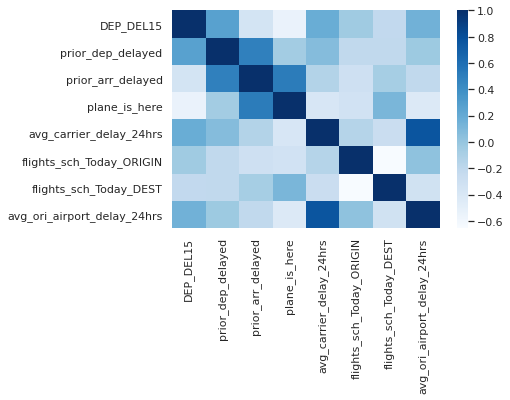

<AxesSubplot:>

In [0]:
sns.heatmap(corr_df.corr(), cmap="Blues")

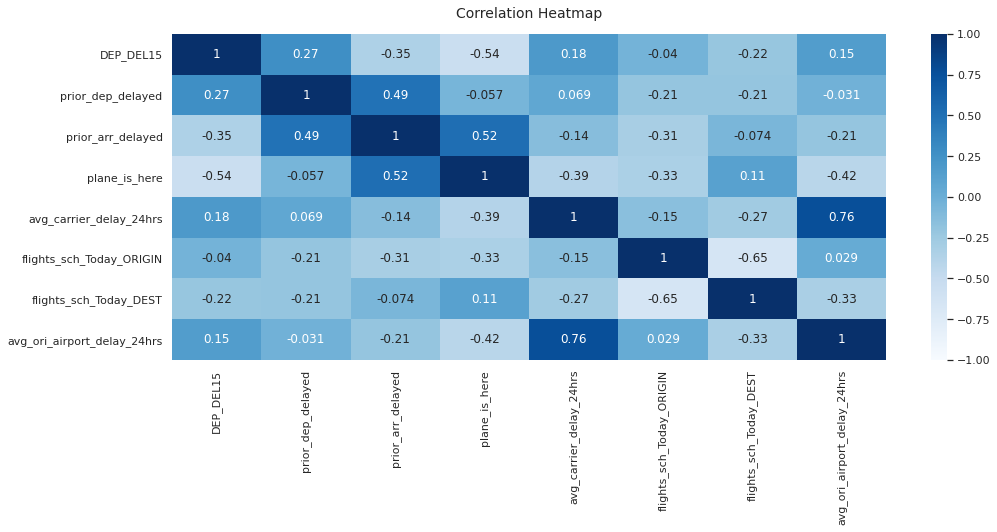

In [0]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
sns.set(style="darkgrid")
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(corr_df.corr(), vmin=-1, vmax=1, annot=True, cmap="Blues")
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=16)
plt.savefig("corr1.png",bbox_inches='tight')

In [0]:
corr_list =  ['DEP_DEL15',
 'late_night',
 'daytime',
 'evening',
 'spring',
 'summer',
 'winter',
 'autumn',
 'weekend_or_holiday']

# ['new_england',
# 'mid_atlantic',
# 'south',
# 'midwest',
# 'southwest',
# 'west',
# 'pacific_islands',
# 'atlantic_islands']

In [0]:
from pyspark.mllib.stat import Statistics
from pyspark.ml.stat import Correlation

corr_WND_df_2 = df_5yr_join_cv.select(corr_list)

col_names_2 = corr_WND_df_2.columns
features_2 = corr_WND_df_2.rdd.map(lambda row:row[0:])
corr_mat_2 = Statistics.corr(features_2, method='pearson')
corr_df_2 = pd.DataFrame(corr_mat_2)

--------------------------------------------------------------------------- 
 ValueError Traceback (most recent call last)
 <command-1898361324245391> in <module> 
 8 corr_mat_2 = Statistics . corr ( features_2 , method = 'pearson' ) 
 9 corr_df_2 = pd . DataFrame ( corr_mat_2 ) 
 ---> 10 corr_df_2 . index , corr_df_2 . columns = col_names , col_names
 11 corr_df_2

 /databricks/python/lib/python3.8/site-packages/pandas/core/generic.py in __setattr__ (self, name, value) 
 5476 try : 
 5477 object . __getattribute__ ( self , name ) 
 -> 5478 return object . __setattr__ ( self , name , value ) 
 5479 except AttributeError : 
 5480 pass 

 pandas/_libs/properties.pyx in pandas._libs.properties.AxisProperty.__set__ () 

 /databricks/python/lib/python3.8/site-packages/pandas/core/generic.py in _set_axis (self, axis, labels) 
 668 def _set_axis ( self , axis : int , labels : Index ) -> None : 
 669 labels = ensure_index ( labels ) 
 --> 670 self . _mgr . set_axis ( axis , labels ) 
 671 self . _clear_item_cache ( ) 
 672 

 /databricks/python/lib/python3.8/site-packages/pandas/core/internals/managers.py in set_axis (self, axis, new_labels) 
 218 
 219 if new_len != old_len : 
 --> 220 raise ValueError(
 221 f"Length mismatch: Expected axis has {old_len} elements, new " 
 222 f"values have {new_len} elements" 

 ValueError : Length mismatch: Expected axis has 9 elements, new values have 8 elements

In [0]:
corr_df_2.index, corr_df_2.columns = col_names_2, col_names_2
corr_df_2

Out[143]:

DEP_DEL15 
 late_night 
 daytime 
 evening 
 spring 
 summer 
 winter 
 autumn 
 weekend_or_holiday 
 
 
 
 
 DEP_DEL15 
 1.000000 
 -0.013740 
 -0.136060 
 0.143902 
 -0.006419 
 0.052340 
 0.011818 
 -0.058557 
 -0.002619 
 
 
 late_night 
 -0.013740 
 1.000000 
 -0.255614 
 -0.217462 
 0.003352 
 0.015625 
 -0.008732 
 -0.010780 
 -0.003956 
 
 
 daytime 
 -0.136060 
 -0.255614 
 1.000000 
 -0.888057 
 -0.003329 
 -0.004496 
 0.001527 
 0.006449 
 0.002786 
 
 
 evening 
 0.143902 
 -0.217462 
 -0.888057 
 1.000000 
 0.001767 
 -0.002891 
 0.002611 
 -0.001384 
 -0.000931 
 
 
 spring 
 -0.006419 
 0.003352 
 -0.003329 
 0.001767 
 1.000000 
 -0.349706 
 -0.321840 
 -0.334994 
 0.091881 
 
 
 summer 
 0.052340 
 0.015625 
 -0.004496 
 -0.002891 
 -0.349706 
 1.000000 
 -0.331086 
 -0.344617 
 -0.052410 
 
 
 winter 
 0.011818 
 -0.008732 
 0.001527 
 0.002611 
 -0.321840 
 -0.331086 
 1.000000 
 -0.317157 
 -0.008468 
 
 
 autumn 
 -0.058557 
 -0.010780 
 0.006449 
 -0.001384 
 -0.334994 
 -0.344617 
 -0.317157 
 1.000000 
 -0.030741 
 
 
 weekend_or_holiday 
 -0.002619 
 -0.003956 
 0.002786 
 -0.000931 
 0.091881 
 -0.052410 
 -0.008468 
 -0.030741 
 1.000000

In [0]:
sns.set()

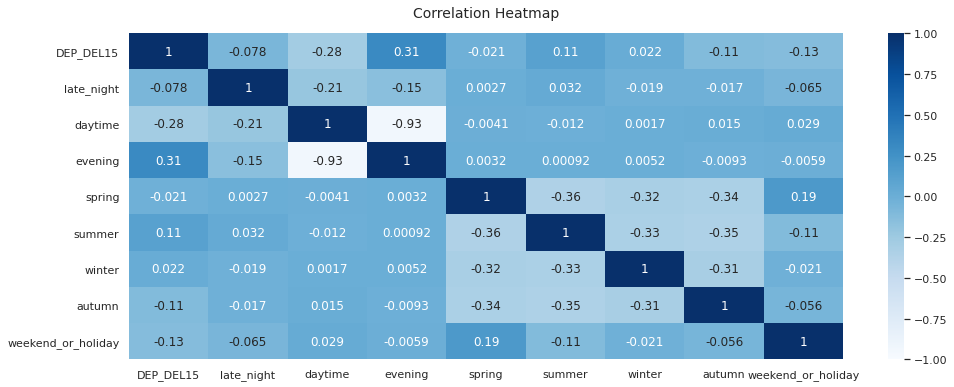

In [0]:
sns.set(style="darkgrid")
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))

# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(corr_df_2.corr(), vmin=-1, vmax=1, annot=True, cmap="Blues")
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=16)
plt.savefig("corr2.png",bbox_inches='tight')

In [0]:
corr_list =  ['DEP_DEL15',
'new_england',
'mid_atlantic',
'south',
'midwest',
'southwest',
'west',
'pacific_islands',
'atlantic_islands']

In [0]:
from pyspark.mllib.stat import Statistics
from pyspark.ml.stat import Correlation

corr_WND_df_3 = df_5yr_join_cv.select(corr_list)

col_names_3 = corr_WND_df_3.columns
features_3 = corr_WND_df_3.rdd.map(lambda row:row[0:])
corr_mat_3 = Statistics.corr(features_3, method='pearson')
corr_df_3 = pd.DataFrame(corr_mat_3)


In [0]:
corr_df_3.index, corr_df_3.columns = col_names_3, col_names_3
corr_df_3

Out[258]:

DEP_DEL15 
 new_england 
 mid_atlantic 
 south 
 midwest 
 southwest 
 west 
 pacific_islands 
 atlantic_islands 
 
 
 
 
 DEP_DEL15 
 1.000000 
 0.002543 
 0.018352 
 -0.003454 
 -0.003602 
 0.007081 
 -0.003903 
 -0.031242 
 0.000229 
 
 
 new_england 
 0.002543 
 1.000000 
 -0.062006 
 -0.112778 
 -0.077933 
 -0.074275 
 -0.105291 
 -0.023575 
 -0.001373 
 
 
 mid_atlantic 
 0.018352 
 -0.062006 
 1.000000 
 -0.217435 
 -0.150254 
 -0.143203 
 -0.203000 
 -0.045453 
 -0.002647 
 
 
 south 
 -0.003454 
 -0.112778 
 -0.217435 
 1.000000 
 -0.273284 
 -0.260459 
 -0.369220 
 -0.082671 
 -0.004814 
 
 
 midwest 
 -0.003602 
 -0.077933 
 -0.150254 
 -0.273284 
 1.000000 
 -0.179985 
 -0.255142 
 -0.057128 
 -0.003326 
 
 
 southwest 
 0.007081 
 -0.074275 
 -0.143203 
 -0.260459 
 -0.179985 
 1.000000 
 -0.243168 
 -0.054447 
 -0.003170 
 
 
 west 
 -0.003903 
 -0.105291 
 -0.203000 
 -0.369220 
 -0.255142 
 -0.243168 
 1.000000 
 -0.077183 
 -0.004494 
 
 
 pacific_islands 
 -0.031242 
 -0.023575 
 -0.045453 
 -0.082671 
 -0.057128 
 -0.054447 
 -0.077183 
 1.000000 
 -0.001006 
 
 
 atlantic_islands 
 0.000229 
 -0.001373 
 -0.002647 
 -0.004814 
 -0.003326 
 -0.003170 
 -0.004494 
 -0.001006 
 1.000000

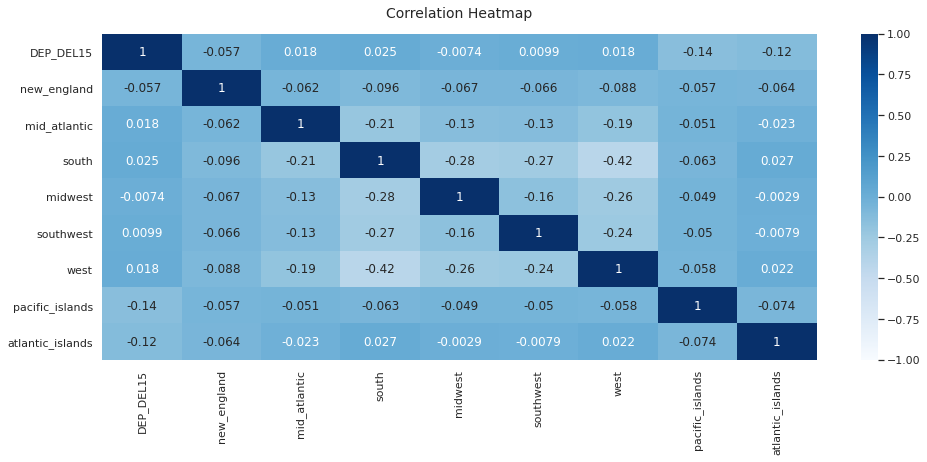

In [0]:
sns.set(style="darkgrid")
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))

# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(corr_df_3.corr(), vmin=-1, vmax=1, annot=True, cmap="Blues")
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=16)
plt.savefig("corr3.png",bbox_inches='tight')

# 2. Train/ Hold-out/ Test split

- As a preparation for cross validation, dataset is splitted by time
- Hold-out data always comes later than train data and test data comes later than all the train/ hold-out data

## Conduct Block Time Series Split (5 years)
CV diagram for the entire dataset:

![CV for Full Data](files/shared_uploads/anand.patel@berkeley.edu/CV_full_data.PNG)

|      | Train                    | Hold-out                 | Test                |
|------|--------------------------|--------------------------|---------------------|
| 1    | 2015-01-01 to 2015-06-30 | 2015-07-01 to 2015-08-31 | -                   |
| 2    | 2015-06-01 to 2015-11-30 | 2015-12-01 to 2016-01-31 | -                   |
| 3    | 2015-11-01 to 2016-04-30 | 2016-05-01 to 2016-06-30 | -                   |
| 4    | 2016-04-01 to 2016-09-30 | 2016-10-01 to 2016-11-30 | -                   |
| 5    | 2016-09-01 to 2017-02-28 | 2017-03-01 to 2016-04-30 | -                   |
| 6    | 2017-02-01 to 2017-07-31 | 2017-08-01 to 2017-09-30 | -                   |
| 7    | 2017-07-01 to 2018-12-31 | 2017-02-01 to 2017-02-28 | -                   |
| 8    | 2017-12-01 to 2018-05-30 | 2018-06-01 to 2018-07-31 | -                   |
| 9    | 2018-05-01 to 2018-10-31 | 2018-11-01 to 2018-12-31 |                     |
| Test | -                        | -                        | 2019-01-01 to end   |

## 2-1. non-hard code version

In [0]:
# change the df when we get access to 5 year dataset
df = df_5yr_join_cv
df.show(5)

+------------------------+--------------+---------+-------------+--------+-------------+--------------+-----------------+----------------------+-----------------+----------------------+-------------+-----------------------+------------------------+----------------------+---------------------------+----------+-------+-------+-----------+------------+-----+-------+---------+----+---------------+----------------+------+------+------+------+------------------+-----+----------+
CRS_DEP_DATETIME_UTC_END|ORI_station_id|DEP_DEL15|DEP_DELAY_NEW|DISTANCE|ORI_elevation|DEST_elevation|prior_dep_delayed|previous_DEP_DELAY_NEW|prior_arr_delayed|previous_ARR_DELAY_NEW|plane_is_here|avg_carrier_delay_24hrs|flights_sch_Today_ORIGIN|flights_sch_Today_DEST|avg_ori_airport_delay_24hrs|late_night|daytime|evening|new_england|mid_atlantic|south|midwest|southwest|west|pacific_islands|atlantic_islands|spring|summer|winter|autumn|weekend_or_holiday|WND_3| DATE|
+------------------------+--------------+---------+-------------+--------+-------------+--------------+-----------------+----------------------+-----------------+----------------------+-------------+-----------------------+------------------------+----------------------+---------------------------+----------+-------+-------+-----------+------------+-----+-------+---------+----+---------------+----------------+------+------+------+------+------------------+-----+----------+
 2018-01-01 17:34:00| 72425003860| 0.0| 0.0| 721.0| 828.0| 11.0| 0| 0.0| 0| 0.0| 0| 0.22| 2| 27| 0.13| 0| 0| 1| 0| 0| 1| 0| 0| 0| 0| 0| 0| 0| 1| 0| 1| 36|2018-01-01|
 2018-01-01 19:19:00| 72425003860| 0.0| 14.0| 665.0| 828.0| 55.0| 1| 22.0| 0| 0.0| 0| 0.26| 2| 21| 0.13| 0| 0| 1| 0| 0| 1| 0| 0| 0| 0| 0| 0| 0| 1| 0| 1| 31|2018-01-01|
 2018-01-02 13:46:00| 72425003860| 1.0| 24.0| 665.0| 828.0| 55.0| 0| 4.0| 0| 0.0| 0| 0.35| 2| 40| 0.0| 0| 1| 0| 0| 0| 1| 0| 0| 0| 0| 0| 0| 0| 1| 0| 1| 21|2018-01-02|
 2018-01-02 19:03:00| 72425003860| 1.0| 24.0| 721.0| 828.0| 11.0| 1| 19.0| 0| 0.0| 0| 0.39| 2| 24| 0.33| 0| 0| 1| 0| 0| 1| 0| 0| 0| 0| 0| 0| 0| 1| 0| 1| 0|2018-01-02|
 2018-01-03 14:16:00| 72425003860| 1.0| 44.0| 665.0| 828.0| 55.0| 0| 10.0| 0| 0.0| 0| 0.44| 1| 19| 1.0| 0| 1| 0| 0| 0| 1| 0| 0| 0| 0| 0| 0| 0| 1| 0| 0| 0|2018-01-03|
+------------------------+--------------+---------+-------------+--------+-------------+--------------+-----------------+----------------------+-----------------+----------------------+-------------+-----------------------+------------------------+----------------------+---------------------------+----------+-------+-------+-----------+------------+-----+-------+---------+----+---------------+----------------+------+------+------+------+------------------+-----+----------+
only showing top 5 rows

In [0]:
# Data split for 5-year CV is calcutated by the latest date

# name latest record as "latest_record"
df_CV_date = df.select(max("DATE")).withColumnRenamed("max(DATE)","latest_record")
# name the start date of test data as test_start
df_CV_date = df_CV_date.withColumn("test_start", add_months("latest_record",-12))


# start date of cv group1: train0
df_CV_date = df_CV_date.withColumn("train0", add_months("latest_record",-60)).cache()
# same as group1, calculate group2 to 8
df_CV_date = df_CV_date.withColumn("train1", add_months("train0",+5))
df_CV_date = df_CV_date.withColumn("train2", add_months("train0",+10))
df_CV_date = df_CV_date.withColumn("train3", add_months("train0",+15))
df_CV_date = df_CV_date.withColumn("train4", add_months("train0",+20))
df_CV_date = df_CV_date.withColumn("train5", add_months("train0",+25))
df_CV_date = df_CV_date.withColumn("train6", add_months("train0",+30))
df_CV_date = df_CV_date.withColumn("train7", add_months("train0",+35))
df_CV_date = df_CV_date.withColumn("train8", add_months("train0",+40))

# start date of cv group1: holdout0
df_CV_date = df_CV_date.withColumn("holdout0", add_months("train0",+6))
df_CV_date = df_CV_date.withColumn("holdout1", add_months("holdout0",+5))
df_CV_date = df_CV_date.withColumn("holdout2", add_months("holdout0",+10))
df_CV_date = df_CV_date.withColumn("holdout3", add_months("holdout0",+15))
df_CV_date = df_CV_date.withColumn("holdout4", add_months("holdout0",+20))
df_CV_date = df_CV_date.withColumn("holdout5", add_months("holdout0",+25))
df_CV_date = df_CV_date.withColumn("holdout6", add_months("holdout0",+30))
df_CV_date = df_CV_date.withColumn("holdout7", add_months("holdout0",+35))
df_CV_date = df_CV_date.withColumn("holdout8", add_months("holdout0",+40))

display(df_CV_date)

latest_record test_start train0 train1 train2 train3 train4 train5 train6 train7 train8 holdout0 holdout1 holdout2 holdout3 holdout4 holdout5 holdout6 holdout7 holdout8 2020-01-01 2019-01-01 2015-01-01 2015-06-01 2015-11-01 2016-04-01 2016-09-01 2017-02-01 2017-07-01 2017-12-01 2018-05-01 2015-07-01 2015-12-01 2016-05-01 2016-10-01 2017-03-01 2017-08-01 2018-01-01 2018-06-01 2018-11-01

In [0]:
#preparing for CV
print(df_CV_date.columns)
for i in df_CV_date.columns:
  print(df_CV_date.collect()[0][i]) #row 0 col 1

['latest_record', 'test_start', 'train0', 'train1', 'train2', 'train3', 'train4', 'train5', 'train6', 'train7', 'train8', 'holdout0', 'holdout1', 'holdout2', 'holdout3', 'holdout4', 'holdout5', 'holdout6', 'holdout7', 'holdout8']
2020-01-01
2019-01-01
2014-12-01
2015-05-01
2015-10-01
2016-03-01
2016-08-01
2017-01-01
2017-06-01
2017-11-01
2018-04-01
2015-06-01
2015-11-01
2016-04-01
2016-09-01
2017-02-01
2017-07-01
2017-12-01
2018-05-01
2018-10-01

In [0]:
# use pandas because operation is much lighter
pdf_CV_date = df_CV_date.cache().toPandas()
pdf_CV_date

Out[167]:

latest_record 
 test_start 
 train0 
 train1 
 train2 
 train3 
 train4 
 train5 
 train6 
 train7 
 train8 
 holdout0 
 holdout1 
 holdout2 
 holdout3 
 holdout4 
 holdout5 
 holdout6 
 holdout7 
 holdout8 
 
 
 
 
 0 
 2020-01-01 
 2019-01-01 
 2015-01-01 
 2015-06-01 
 2015-11-01 
 2016-04-01 
 2016-09-01 
 2017-02-01 
 2017-07-01 
 2017-12-01 
 2018-05-01 
 2015-07-01 
 2015-12-01 
 2016-05-01 
 2016-10-01 
 2017-03-01 
 2017-08-01 
 2018-01-01 
 2018-06-01 
 2018-11-01

In [0]:
# list of features(this list is updated everytime we change the features)
Features_for_cv = ['CRS_DEP_DATETIME_UTC_END'] + ['ORI_station_id'] + Outcomes_for_flights + Features_for_flights + ['WND_3']

# list of name of the dataset
cv_group_list = [['train0','holdout0'],['train1','holdout1'],['train2','holdout2'],
                 ['train3','holdout3'],['train4','holdout4'],['train5','holdout5'],
                 ['train6','holdout6'],['train7','holdout7'],['train8','holdout8']]


def CVSplit_full1(df, cv_group, feature_list):
  
  global pdf_CV_date#df_CV_date
  
  # assign start date
  train_start_date = pdf_CV_date[cv_group[0]][0]
  holdout_start_date = pdf_CV_date[cv_group[1]][0]
  print(f'{cv_group[0]}_start: {train_start_date}, {cv_group[1]}_start: {holdout_start_date}')

  # calculate end date of train/holdout data
  pdf_CV_date[cv_group[0]+'_end'] = train_start_date + relativedelta(months=+5)
  pdf_CV_date[cv_group[1]+'_end'] = holdout_start_date + relativedelta(months=+2)
  
  # calculate end date of train/holdout data
  train_end_date = train_start_date + relativedelta(months=+6) - timedelta(days=1)
  holdout_end_date = holdout_start_date + relativedelta(months=+2) - timedelta(days=1)
  print(f'{cv_group[0]}_end:   {train_end_date}, {  cv_group[1]}_end:   {holdout_end_date}')
    
  # train = df_5yr_join_cv.filter((df_5yr_join_cv.DATE >= train_start_date) & (df_5yr_join_cv.DATE <= train_end_date))
  # holdout = df_5yr_join_cv.filter((df_5yr_join_cv.DATE >= holdout_start_date) & (df_5yr_join_cv.DATE <= holdout_end_date))
  train = df.filter((df.DATE >= train_start_date) & (df.DATE <= train_end_date))
  holdout = df.filter((df.DATE >= holdout_start_date) & (df.DATE <= holdout_end_date))
  
  train = train.select(feature_list + ['DEP_DEL15'])# + ['DATE']) # have date column to check if the date is splitted correctly
  holdout = holdout.select(feature_list + ['DEP_DEL15'])# + ['DATE']) # have date column to check if the date is splitted correctly
  
  # If we want to split to X and Y, use the code below
  #   train_X = train.select(feature_list)
  #   train_Y = train.select(['DEP_DEL15'])
  #   holdout_X = holdout.select(feature_list)
  #   holdout_Y = holdout.select(['DEP_DEL15'])
  
  return train, holdout

train0, holdout0 = CVSplit_full1(df_5yr_join_cv, cv_group_list[0], Features_for_cv)
train1, holdout1 = CVSplit_full1(df_5yr_join_cv, cv_group_list[1], Features_for_cv)
train2, holdout2 = CVSplit_full1(df_5yr_join_cv, cv_group_list[2], Features_for_cv)
train3, holdout3 = CVSplit_full1(df_5yr_join_cv, cv_group_list[3], Features_for_cv)
train4, holdout4 = CVSplit_full1(df_5yr_join_cv, cv_group_list[4], Features_for_cv)
train5, holdout5 = CVSplit_full1(df_5yr_join_cv, cv_group_list[5], Features_for_cv)
train6, holdout6 = CVSplit_full1(df_5yr_join_cv, cv_group_list[6], Features_for_cv)
train7, holdout7 = CVSplit_full1(df_5yr_join_cv, cv_group_list[7], Features_for_cv)
train8, holdout8 = CVSplit_full1(df_5yr_join_cv, cv_group_list[8], Features_for_cv)

# have date column to check if the date is splitted correctly
test = df_5yr_join_cv.filter(df_5yr_join_cv.DATE >= df_CV_date.collect()[0]['test_start']).select(Features_for_cv)# + ['DATE'])
print(f'test_start: ')
df_CV_date.collect()[0]['test_start']

train0_start: 2015-01-01, holdout0_start: 2015-07-01
train0_end: 2015-06-30, holdout0_end: 2015-08-31
train1_start: 2015-06-01, holdout1_start: 2015-12-01
train1_end: 2015-11-30, holdout1_end: 2016-01-31
train2_start: 2015-11-01, holdout2_start: 2016-05-01
train2_end: 2016-04-30, holdout2_end: 2016-06-30
train3_start: 2016-04-01, holdout3_start: 2016-10-01
train3_end: 2016-09-30, holdout3_end: 2016-11-30
train4_start: 2016-09-01, holdout4_start: 2017-03-01
train4_end: 2017-02-28, holdout4_end: 2017-04-30
train5_start: 2017-02-01, holdout5_start: 2017-08-01
train5_end: 2017-07-31, holdout5_end: 2017-09-30
train6_start: 2017-07-01, holdout6_start: 2018-01-01
train6_end: 2017-12-31, holdout6_end: 2018-02-28
train7_start: 2017-12-01, holdout7_start: 2018-06-01
train7_end: 2018-05-31, holdout7_end: 2018-07-31
train8_start: 2018-05-01, holdout8_start: 2018-11-01
train8_end: 2018-10-31, holdout8_end: 2018-12-31
test_start: 
Out[190]: datetime.date(2019, 1, 1)

## 2-2. Hard-code version

In [0]:
# Assuming to use df_5yr_join_cv as a clean dataset

Features_for_cv = ['CRS_DEP_DATETIME_UTC_END'] + ['ORI_station_id'] + Outcomes_for_flights + Features_for_flights + ['WND_3']

# [[train_start, train_end],[holdout_start, holdout_end]]
cv_date_list=[[['2015-01-01', '2015-06-30'],['2015-07-01','2015-08-31']],
             [['2015-06-01', '2015-11-30'],['2015-12-01', '2016-01-31']],
             [['2015-11-01', '2016-04-30'],['2016-05-01', '2016-06-30']],
             [['2016-04-01', '2016-09-30'],['2016-10-01', '2016-11-30']],
             [['2016-09-01', '2017-02-28'],['2017-03-01', '2017-04-30']],
             [['2017-02-01', '2017-07-31'],['2017-08-01', '2017-09-30']],
             [['2017-07-01', '2017-12-31'],['2018-01-01', '2018-02-28']],
             [['2017-12-01', '2018-05-31'],['2018-06-01', '2018-07-31']],
             [['2018-05-01', '2018-10-31'],['2018-11-01', '2018-12-31']]]
test_start_date = '2019-01-01'


def CVSplit_full2(date_list,feature_list):
  train = df_5yr_join_cv.filter((df_5yr_join_cv.DATE >= date_list[0][0]) & (df_5yr_join_cv.DATE <= date_list[0][1]))
  holdout = df_5yr_join_cv.filter((df_5yr_join_cv.DATE >= date_list[1][0]) & (df_5yr_join_cv.DATE <= date_list[1][1]))
  
  train = train.select(feature_list + ['DEP_DEL15'])
  holdout = holdout.select(feature_list + ['DEP_DEL15'])
  
  train_X = train.select(feature_list)
  train_Y = train.select(['DEP_DEL15'])
  holdout_X = holdout.select(feature_list)
  holdout_Y = holdout.select(['DEP_DEL15'])
  
  return train, holdout

train0, holdout0 = CVSplit_full2(cv_date_list[0], Features_for_cv)
train1, holdout1 = CVSplit_full2(cv_date_list[1], Features_for_cv)
train2, holdout2 = CVSplit_full2(cv_date_list[2], Features_for_cv)
train3, holdout3 = CVSplit_full2(cv_date_list[3], Features_for_cv)
train4, holdout4 = CVSplit_full2(cv_date_list[4], Features_for_cv)
train5, holdout5 = CVSplit_full2(cv_date_list[5], Features_for_cv)
train6, holdout6 = CVSplit_full2(cv_date_list[6], Features_for_cv)
train7, holdout7 = CVSplit_full2(cv_date_list[7], Features_for_cv)
train8, holdout8 = CVSplit_full2(cv_date_list[8], Features_for_cv)

test = df_5yr_join_cv.filter(df_5yr_join_cv.DATE >= test_start_date[0]).select(Features_for_cv)

In [0]:
# see if we gain '2017-07-01'
display(train6.agg(min("CRS_DEP_DATETIME_UTC_END")))
# see if we gain '2017-12-31'
display(train6.agg(max("CRS_DEP_DATETIME_UTC_END")))


min(CRS_DEP_DATETIME_UTC_END) 2017-07-01T00:00:00.000+0000

max(CRS_DEP_DATETIME_UTC_END) 2017-12-31T23:59:00.000+0000

In [0]:
# see if we gain '2019-01-01'
display(test.agg(min("CRS_DEP_DATETIME_UTC_END")))
# see if we gain '2020-01-01'
display(test.agg(max("CRS_DEP_DATETIME_UTC_END")))

min(CRS_DEP_DATETIME_UTC_END) 2019-01-01T00:00:00.000+0000

max(CRS_DEP_DATETIME_UTC_END) 2020-01-01T05:55:00.000+0000

# 3. Modeling - Random Forest Classifier 
Logistic Regression (single dataset)

- Input variable: `DISTANCE`
- Logistic regression: `DEP_DEL15`

In [0]:
# imports
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import MinMaxScaler
from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder


## One-Hot Encoding

OneHotEncoderEstimator is not available in Databricks
Use OneHotEncoder instead

#### How to use OneHotEncoder
https://docs.microsoft.com/en-us/azure/databricks/_static/notebooks/getting-started/get-started-with-mllib-dbr7.html

OneHotEncoderEstimator is unavailable in Databricks

In [0]:
from pyspark.ml import Pipeline

# https://kb.databricks.com/machine-learning/onehotencoderestimator-error.html

# # from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer
# encoder = OneHotEncoder().setInputCols(['WND_2']).setOutputCol(['WND_2_encoded'])
# one_hot_encoder_model = encoder.fit(df_5yr_join_cv)
# encoder_df = encoder_model.transform(df_5yr_join_cv)
# encoder_df.toPandas().head()

### StringIndexer

- Convert string categorical variables to numeric variables

In [0]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
 
categoricalCols = ['WND_2']
 
# The following two lines are estimators. They return functions that we will later apply to transform the dataset.
stringIndexer = StringIndexer(inputCols=categoricalCols, outputCols=[x + "_Index" for x in categoricalCols]) 
encoder = OneHotEncoder(inputCols=stringIndexer.getOutputCols(), outputCols=[x + "_OHE" for x in categoricalCols]) 
 
# Example
# If the label column ("income") is also a string value - let's say it has two possible values, "<=50K" and ">50K". 
# Convert it to a numeric value using StringIndexer.
# labelToIndex = StringIndexer(inputCol="income", outputCol="label")

WND_2 is encoded numerically in column "WND_2_Index"

In [0]:
stringIndexerModel = stringIndexer.fit(train0)
train0_STI = stringIndexerModel.transform(train0) # STI = StringIndexer
display(train0_STI)

# same operation for holdout data
# stringIndexerModel = stringIndexer.fit(holdout0)
holdout0_STI = stringIndexerModel.transform(holdout0) # STI = StringIndexer
display(holdout0_STI)

### OneHotEncoder

Transform the string values by `stringIndexer.fit` `stringIndexer.transform` first, and then use OneHotEncoder.

Output is assigned in the column 'WND_2_OHE'

In [0]:
encoder = OneHotEncoder(inputCols=["WND_2_Index"],
                        outputCols=["WND_2_OHE"])
model = encoder.fit(train0_STI)
train0_OHE = model.transform(train0_STI) # OHE = OneHotEncoding
display(train0_OHE)

# model = encoder.fit(holdout0_STI)
holdout0_OHE = model.transform(holdout0_STI) # OHE = OneHotEncoding
display(holdout0_OHE)

## Assemble features

In [0]:
feature_list = ['DISTANCE', 'WND_3']#'WND_0', 'WND_2_OHE', 

In [0]:
# Assemble features
assembler = VectorAssembler().setInputCols(feature_list)\
                            .setOutputCol('vectorized_features')

In [0]:
assmb_train0 = assembler.transform(train0)#train0_OHE)
assmb_holdout0 = assembler.transform(holdout0)#_OHE)

In [0]:
display(assmb_train0)

CRS_DEP_DATETIME_UTC_END ORI_station_id DEP_DEL15 DEP_DELAY_NEW DISTANCE ORI_elevation DEST_elevation prior_dep_delayed previous_DEP_DELAY_NEW prior_arr_delayed previous_ARR_DELAY_NEW plane_is_here avg_carrier_delay_24hrs flights_sch_Today_ORIGIN flights_sch_Today_DEST avg_ori_airport_delay_24hrs late_night daytime evening new_england mid_atlantic south midwest southwest west pacific_islands atlantic_islands spring summer winter autumn weekend_or_holiday WND_3 DEP_DEL15 vectorized_features 2015-01-01T06:10:00.000+0000 72295023174 0.0 0.0 2330.0 125.0 19.0 0 0.0 0 0.0 0 0.12 553 81 0.13 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0.0 Map(vectorType -> dense, length -> 2, values -> List(2330.0, 0.0)) 2015-01-01T06:20:00.000+0000 72295023174 0.0 0.0 2342.0 125.0 8.0 0 0.0 0 0.0 0 0.12 553 208 0.13 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0.0 Map(vectorType -> dense, length -> 2, values -> List(2342.0, 0.0)) 2015-01-01T06:30:00.000+0000 72295023174 0.0 14.0 2125.0 125.0 748.0 0 0.0 0 0.0 0 0.12 553 284 0.13 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0.0 Map(vectorType -> dense, length -> 2, values -> List(2125.0, 0.0)) 2015-01-01T06:35:00.000+0000 72295023174 0.0 0.0 1535.0 125.0 841.0 0 0.0 0 0.0 0 0.12 553 211 0.13 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0.0 Map(vectorType -> dense, length -> 2, values -> List(1535.0, 0.0)) 2015-01-01T07:05:00.000+0000 72295023174 0.0 0.0 2342.0 125.0 8.0 0 0.0 0 0.0 0 0.12 553 208 0.13 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 21 0.0 Map(vectorType -> dense, length -> 2, values -> List(2342.0, 21.0)) 2015-01-01T07:15:00.000+0000 72295023174 0.0 0.0 1379.0 125.0 97.0 0 0.0 0 0.0 0 0.12 553 411 0.13 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 21 0.0 Map(vectorType -> dense, length -> 2, values -> List(1379.0, 21.0)) 2015-01-01T11:50:00.000+0000 72295023174 0.0 0.0 862.0 125.0 5431.0 0 0.0 0 0.0 0 0.12 553 559 0.0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 15 0.0 Map(vectorType -> dense, length -> 2, values -> List(862.0, 15.0)) 2015-01-01T11:50:00.000+0000 72295023174 0.0 10.0 1235.0 125.0 607.0 0 0.0 0 0.0 0 0.21 553 622 0.0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 15 0.0 Map(vectorType -> dense, length -> 2, values -> List(1235.0, 15.0)) 2015-01-01T11:57:00.000+0000 72295023174 0.0 0.0 1379.0 125.0 97.0 0 0.0 0 0.0 0 0.11 553 411 0.0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 21 0.0 Map(vectorType -> dense, length -> 2, values -> List(1379.0, 21.0)) 2015-01-01T12:00:00.000+0000 72295023174 0.0 0.0 954.0 125.0 433.0 0 0.0 0 0.0 0 0.0 553 276 0.0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 21 0.0 Map(vectorType -> dense, length -> 2, values -> List(954.0, 21.0)) 2015-01-01T12:00:00.000+0000 72295023174 0.0 7.0 1744.0 125.0 672.0 0 0.0 0 0.0 0 0.12 553 670 0.0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 21 0.0 Map(vectorType -> dense, length -> 2, values -> List(1744.0, 21.0)) 2015-01-01T12:00:00.000+0000 72295023174 0.0 0.0 1947.0 125.0 1026.0 0 0.0 0 0.0 0 0.06 553 696 0.0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 21 0.0 Map(vectorType -> dense, length -> 2, values -> List(1947.0, 21.0)) 2015-01-01T12:00:00.000+0000 72295023174 0.0 0.0 1744.0 125.0 672.0 0 0.0 0 0.0 0 0.16 553 670 0.0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 21 0.0 Map(vectorType -> dense, length -> 2, values -> List(1744.0, 21.0)) 2015-01-01T12:03:00.000+0000 72295023174 0.0 0.0 2454.0 125.0 18.0 0 0.0 0 0.0 0 0.12 553 267 0.0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 21 0.0 Map(vectorType -> dense, length -> 2, values -> List(2454.0, 21.0)) 2015-01-01T12:03:00.000+0000 72295023174 0.0 0.0 337.0 125.0 13.0 0 0.0 0 0.0 0 0.12 553 411 0.0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 21 0.0 Map(vectorType -> dense, length -> 2, values -> List(337.0, 21.0)) 2015-01-01T12:10:00.000+0000 72295023174 0.0 10.0 2475.0 125.0 13.0 0 0.0 0 0.0 0 0.05 553 255 0.0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 21 0.0 Map(vectorType -> dense, length -> 2, values -> List(2475.0, 21.0)) 2015-01-01T12:10:00.000+0000 72295023174 0.0 0.0 1592.0 125.0 618.0 0 0.0 0 0.0 0 0.16 553 104 0.0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 21 0.0 Map(vectorType -> dense, length -> 2, values -> List(1592.0, 21.0)) 2015-01-01T12:13:0

## Normalize features

In [0]:
# normalize dataset
scaler = MinMaxScaler().setInputCol('vectorized_features')\
                            .setOutputCol('normalized_features')

scaler_model0 = scaler.fit(assmb_train0)
normed_train0 = scaler_model0.transform(assmb_train0)
normed_holdout0 = scaler_model0.transform(assmb_holdout0)

In [0]:
display(normed_train0)

In [0]:
normed_train0.toPandas()

## Fit model

### Reference - Logistic regression

In [0]:
from pyspark.ml.classification import LogisticRegression

# model with normed_train0, normed_holdout0
lr = LogisticRegression(featuresCol = 'normalized_features', labelCol = 'DEP_DEL15', maxIter=5)
lrModel = lr.fit(normed_train0)
predictions = lrModel.transform(normed_holdout0)
predictions.select('DEP_DEL15','normalized_features')

### Random Forest Classifier

In [0]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'normalized_features', labelCol = 'DEP_DEL15')
rfModel = rf.fit(normed_train0)
predictions = rfModel.transform(normed_holdout0)

In [0]:
# predictions.select('sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'labelIndex', 'rawPrediction', 'prediction', 'probability').show(25)
predictions.select("prediction", "DEP_DEL15", "probability","rawPrediction").show(5)

### Feature Importance in RF

In [0]:
rfModel.featureImportances

## CV with Feature Importance + loop

In [0]:
Outcomes_for_flights

Out[194]: ['DEP_DEL15', 'DEP_DELAY_NEW']

In [0]:
Features_for_RF = ['DEP_DEL15'] + Features_for_flights + ['WND_3']

In [0]:
import timeit
start = timeit.default_timer()

Features_for_RF = ['DEP_DEL15'] + Features_for_flights + ['WND_3']

# list of name of the dataset
cv_group_list = [[train0, holdout0],[train1, holdout1],[train2,holdout2],
                 [train3, holdout3],[train4, holdout4],[train5,holdout5],
                 [train6, holdout6],[train7, holdout7],[train8,holdout8]]

feature_importances_cv_loop_WND = [['cv_group','loop_num'] + Features_for_flights + ['WND_3']]

for i in range(3): # random number of loop
  for idx, dataset in enumerate(cv_group_list): # loop through cv split groups
    
    # StringIndexer #################################################################
#     stringIndexerModel = stringIndexer.fit(dataset[0])
#     train_STI = stringIndexerModel.transform(dataset[0]) # STI = StringIndexer
    
#     # same operation for holdout data
#     holdout_STI = stringIndexerModel.transform(dataset[1]) # STI = StringIndexer
    
#     # OneHotEncoder #################################################################
#     encoder = OneHotEncoder(inputCols=["WND_2_Index"],
#                         outputCols=["WND_2_OHE"])
#     model = encoder.fit(train0_STI)
#     train_OHE = model.transform(train_STI) # OHE = OneHotEncoding

#     # model = encoder.fit(holdout0_STI)
#     holdout_OHE = model.transform(holdout_STI) # OHE = OneHotEncoding
    train = dataset[0].select(Features_for_RF)
    holdout = dataset[1].select(Features_for_RF)
  
    # Assembling #################################################################
    # Assemble features
    assembler = VectorAssembler().setInputCols(Features_for_flights + ['WND_3'])\
                              .setOutputCol('vectorized_features')

    assmb_train = assembler.transform(train)
    assmb_holdout = assembler.transform(holdout)
    
    # Normalization #################################################################
    scaler = StandardScaler().setInputCol('vectorized_features')\
                                .setOutputCol('normalized_features')

    scaler_model = scaler.fit(assmb_train)
    normed_train = scaler_model.transform(assmb_train)
    normed_holdout = scaler_model.transform(assmb_holdout)
    
    # Random Forest Classifier ######################################################
    rf = RandomForestClassifier(featuresCol = 'normalized_features', labelCol = 'DEP_DEL15')
    rfModel = rf.fit(normed_train)
    predictions = rfModel.transform(normed_holdout)
    
    # Feature importance in ######################################################
    feature_importance = rfModel.featureImportances
    feature_importances_cv_loop_WND += [[idx,i] + list(feature_importance)]

    
stop = timeit.default_timer()
print('Time: ', stop - start)  

Time: 3472.3072877079976

In [0]:
# convert list to pandas df
df_feature_importance = pd.DataFrame(feature_importances_cv_loop,columns= ['cv_group','loop_num'] + Features_for_flights)
df_feature_importance

Out[241]:

cv_group 
 loop_num 
 DISTANCE 
 ORI_elevation 
 DEST_elevation 
 prior_dep_delayed 
 previous_DEP_DELAY_NEW 
 prior_arr_delayed 
 previous_ARR_DELAY_NEW 
 plane_is_here 
 avg_carrier_delay_24hrs 
 flights_sch_Today_ORIGIN 
 flights_sch_Today_DEST 
 avg_ori_airport_delay_24hrs 
 late_night 
 daytime 
 evening 
 new_england 
 mid_atlantic 
 south 
 midwest 
 southwest 
 west 
 pacific_islands 
 atlantic_islands 
 spring 
 summer 
 winter 
 autumn 
 weekend_or_holiday 
 
 
 
 
 0 
 cv_group 
 loop_num 
 DISTANCE 
 ORI_elevation 
 DEST_elevation 
 prior_dep_delayed 
 previous_DEP_DELAY_NEW 
 prior_arr_delayed 
 previous_ARR_DELAY_NEW 
 plane_is_here 
 avg_carrier_delay_24hrs 
 flights_sch_Today_ORIGIN 
 flights_sch_Today_DEST 
 avg_ori_airport_delay_24hrs 
 late_night 
 daytime 
 evening 
 new_england 
 mid_atlantic 
 south 
 midwest 
 southwest 
 west 
 pacific_islands 
 atlantic_islands 
 spring 
 summer 
 winter 
 autumn 
 weekend_or_holiday 
 
 
 1 
 0 
 0 
 0.000898 
 0.000259 
 0.000125 
 0.211628 
 0.390659 
 0.058105 
 0.091978 
 0.102686 
 0.051063 
 0.000096 
 0.000534 
 0.016152 
 0.00144 
 0.021521 
 0.051769 
 0.0 
 0.0 
 0.0 
 0.000104 
 0.00013 
 0.00001 
 0.000446 
 0.0 
 0.000382 
 0.0 
 0.000013 
 0.0 
 0.0 
 
 
 2 
 1 
 0 
 0.000951 
 0.000104 
 0.000101 
 0.222346 
 0.404048 
 0.054908 
 0.0908 
 0.094529 
 0.043053 
 0.000001 
 0.000392 
 0.010291 
 0.001468 
 0.023139 
 0.050796 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.000271 
 0.0 
 0.0 
 0.00031 
 0.0 
 0.00211 
 0.000381 
 
 
 3 
 2 
 0 
 0.001608 
 0.00044 
 0.000507 
 0.237186 
 0.42242 
 0.050635 
 0.097235 
 0.075907 
 0.04059 
 0.000249 
 0.000098 
 0.016482 
 0.001723 
 0.015424 
 0.038397 
 0.0 
 0.0 
 0.0 
 0.0 
 0.000041 
 0.0 
 0.000981 
 0.0 
 0.0 
 0.0 
 0.000078 
 0.0 
 0.0 
 
 
 4 
 3 
 0 
 0.001358 
 0.000076 
 0.000079 
 0.240269 
 0.381573 
 0.054416 
 0.093305 
 0.084851 
 0.032907 
 0.000114 
 0.000457 
 0.006709 
 0.001505 
 0.023775 
 0.075018 
 0.0 
 0.000001 
 0.000023 
 0.0 
 0.000015 
 0.0 
 0.000951 
 0.0 
 0.000368 
 0.002204 
 0.0 
 0.0 
 0.000026 
 
 
 5 
 4 
 0 
 0.000111 
 0.000468 
 0.000273 
 0.231873 
 0.392657 
 0.028303 
 0.103673 
 0.098144 
 0.050102 
 0.000315 
 0.000512 
 0.023793 
 0.000805 
 0.013288 
 0.047011 
 0.0 
 0.0 
 0.000672 
 0.0 
 0.000156 
 0.00166 
 0.0 
 0.0 
 0.0 
 0.0 
 0.004184 
 0.00124 
 0.00076 
 
 
 6 
 5 
 0 
 0.000614 
 0.001427 
 0.000791 
 0.239911 
 0.37922 
 0.058062 
 0.093978 
 0.095155 
 0.022181 
 0.00003 
 0.000491 
 0.018225 
 0.001279 
 0.021411 
 0.064897 
 0.0 
 0.0 
 0.000027 
 0.0 
 0.0 
 0.0 
 0.000603 
 0.0 
 0.0 
 0.000844 
 0.000854 
 0.0 
 0.0 
 
 
 7 
 6 
 0 
 0.000314 
 0.00029 
 0.00046 
 0.261751 
 0.391421 
 0.047182 
 0.094317 
 0.088843 
 0.030477 
 0.0 
 0.000292 
 0.014655 
 0.001433 
 0.021313 
 0.045625 
 0.0 
 0.0 
 0.0 
 0.0 
 0.000012 
 0.0 
 0.000689 
 0.0 
 0.0 
 0.000221 
 0.000202 
 0.000502 
 0.0 
 
 
 8 
 7 
 0 
 0.000301 
 0.000181 
 0.000269 
 0.257776 
 0.399509 
 0.055474 
 0.086751 
 0.098242 
 0.036813 
 0.000134 
 0.000409 
 0.006095 
 0.00126 
 0.016843 
 0.039324 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.000362 
 0.0 
 0.000132 
 0.0 
 0.000123 
 0.0 
 0.0 
 
 
 9 
 8 
 0 
 0.000873 
 0.000063 
 0.000238 
 0.244254 
 0.374582 
 0.066342 
 0.095466 
 0.082818 
 0.028348 
 0.000166 
 0.000601 
 0.004393 
 0.001269 
 0.023342 
 0.074355 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.000897 
 0.0 
 0.000024 
 0.001112 
 0.0 
 0.000766 
 0.000092

In [0]:
feature_importances_cv_loop3
df_feature_importance_cv_loop3 = pd.DataFrame(feature_importances_cv_loop3[1:],columns= ['cv_group','loop_num'] + Features_for_flights)

In [0]:
display(df_feature_importances_cv_loop3)

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-1898361324246842> in <module> 
 ----> 1 display ( df_feature_importances_cv_loop3 ) 

 NameError : name 'df_feature_importances_cv_loop3' is not defined

In [0]:
df_feature_importance_cv_loop3.write.parquet(f"{blob_url}/df_RF_feature_importance_loop3_0326")

--------------------------------------------------------------------------- 
 AttributeError Traceback (most recent call last)
 <command-1898361324233180> in <module> 
 ----> 1 df_feature_importance_cv_loop3 . write . parquet ( f"{blob_url}/df_RF_feature_importance_loop3_0326" ) 

 /databricks/python/lib/python3.8/site-packages/pandas/core/generic.py in __getattr__ (self, name) 
 5463 if self . _info_axis . _can_hold_identifiers_and_holds_name ( name ) : 
 5464 return self [ name ] 
 -> 5465 return object . __getattribute__ ( self , name ) 
 5466 
 5467 def __setattr__ ( self , name : str , value ) -> None : 

 AttributeError : 'DataFrame' object has no attribute 'write'

In [0]:
df_feature_importance_WND = pd.DataFrame(feature_importances_cv_WND[1:],columns= ['cv_group','loop_num'] + Features_for_flights)
df_feature_importance_WND.write.parquet(f"{blob_url}/df_RF_feature_importance_WND_0326")

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-1898361324246833> in <module> 
 ----> 1 df_feature_importance_WND = pd . DataFrame ( feature_importances_cv_WND [ 1 : ] , columns = [ 'cv_group' , 'loop_num' ] + Features_for_flights ) 
 2 df_feature_importance_WND . write . parquet ( f"{blob_url}/df_RF_feature_importance_WND_0326" ) 

 NameError : name 'feature_importances_cv_WND' is not defined

In [0]:
normed_train0.toPandas()

# 3.5 Feature Selection in RF

In [0]:
display(normed_train0)

### Sample code for hyperparameter tuning / CV in RF(not working as of March 24)

In [0]:
# from pyspark.ml.tuning import ParamGridBuilder
# from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
# from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# classifier = RandomForestClassifier()
# paramGrid = (ParamGridBuilder()\
#             .addGrid(classifier.maxDepth, [2, 5, 10])
#             .addGrid(classifier.maxBins, [5, 10 , 20])
#             .addGrid(classifier.numTrees,[5, 20, 50])
#             .build())
# crossval = CrossValidator(estimator=classifier,
#                           estimatorParamMaps=paramGrid,
#                           evaluator=MulticlassClassificationEvaluator(),
#                           numFolds=2)

# fitModel = crossval.fit(normed_train0.select[])
# BestModel= fitModel.bestModel
# featureImportances= BestModel.featureImportances.toArray()

In [0]:
# classifier = RandomForestClassifier()
# n = 2
# print("Testing top n= ", n, " features")

# best_n_features= featureImportances.argsort()[-n:][::-1]
# best_n_features= best_n_features.tolist()
# vs= VectorSlicer(inputCol='features',   outputCol='best_features',indices=best_n_features)
# bestFeaturesDf= vs.transform(final_data)
# train,test= bestFeaturesDf.randomSplit([0.7, 0.3])

# columns = ['Classifier', 'Result']
# vals = [('Place Holder', 'N/A')]
# results = spark.createDataFrame(vals, columns)

# paramGrid = (ParamGridBuilder()\
#         .addGrid(classifier.maxDepth, [2, 5, 10])
#         .addGrid(classifier.maxBins, [5, 10 , 20])
#         .addGrid(classifier.numTrees,[5, 20, 50])
#         .build())
# crossval = CrossValidator(estimator=classifier,
#                      estimatorParamMaps=paramGrid,
#                      evaluator=MulticlassClassificationEvaluator(),
#                      numFolds=2)
# fitModel = crossval.fit(train)

# BestModel= fitModel.bestModel
# featureImportances= BestModel.featureImportances.toArray()
# print("Feature Importances: ", featureImportances)
# predictions = fitModel.transform(test)
# accuracy = (MC_evaluator.evaluate(predictions))*100
# print(" ")
# print("Accuracy: ", accuracy)

In [0]:
# classifier = RandomForestClassifier()
# for n in range(10, maximum, 10):
#     print("Testiang top n= ", n, " features")
    
#     best_n_features= featureImportances.argsort()[-n:][::-1]
#     best_n_features= best_n_features.tolist()
#     vs= VectorSlicer(inputCol='features',   outputCol='best_features',indices=best_n_features)
#     bestFeaturesDf= vs.transform(final_data)
#     train,test= bestFeaturesDf.randomSplit([0.7, 0.3])
    
#     columns = ['Classifier', 'Result']
#     vals = [('Place Holder', 'N/A')]
#     results = spark.createDataFrame(vals, columns)
    
#     paramGrid = (ParamGridBuilder()\
#             .addGrid(classifier.maxDepth, [2, 5, 10])
#             .addGrid(classifier.maxBins, [5, 10 , 20])
#             .addGrid(classifier.numTrees,[5, 20, 50])
#             .build())
# crossval = CrossValidator(estimator=classifier,
#                          estimatorParamMaps=paramGrid,
#                          evaluator=MulticlassClassificationEvaluator(),
#                          numFolds=2)
# fitModel = crossval.fit(train)

# BestModel= fitModel.bestModel
# featureImportances= BestModel.featureImportances.toArray()
# print("Feature Importances: ", featureImportances)
# predictions = fitModel.transform(test)
# accuracy = (MC_evaluator.evaluate(predictions))*100
# print(" ")
# print("Accuracy: ", accuracy)

Reference 2
https://medium.com/rahasak/random-forest-classifier-with-apache-spark-c63b4a23a7cc

In [0]:
display(normed_train0)

# 4. Full data CV

In [0]:
# Assuming to use df_5yr_join_cv as a clean dataset

Features_for_cv = ['CRS_DEP_DATETIME_UTC_END'] + ['ORI_station_id'] + Outcomes_for_flights + Features_for_flights + ['WND_3']
print(Features_for_cv)

# [[train_start, train_end],[holdout_start, holdout_end]]
cv_date_list=[[['2015-01-01', '2015-06-30'],['2015-07-01','2015-08-31']],
             [['2015-06-01', '2015-11-30'],['2015-12-01', '2016-01-31']],
             [['2015-11-01', '2016-04-30'],['2016-05-01', '2016-06-30']],
             [['2016-04-01', '2016-09-30'],['2016-10-01', '2016-11-30']],
             [['2016-09-01', '2017-02-28'],['2017-03-01', '2017-04-30']],
             [['2017-02-01', '2017-07-31'],['2017-08-01', '2017-09-30']],
             [['2017-07-01', '2017-12-31'],['2018-01-01', '2018-02-28']],
             [['2017-12-01', '2018-05-31'],['2018-06-01', '2018-07-31']],
             [['2018-05-01', '2018-10-31'],['2018-11-01', '2018-12-31']]]
test_start_date = '2019-01-01'


def CVSplit_full2(date_list,feature_list):
  train = df_5yr_join_cv.filter((df_5yr_join_cv.DATE >= date_list[0][0]) & (df_5yr_join_cv.DATE <= date_list[0][1]))
  holdout = df_5yr_join_cv.filter((df_5yr_join_cv.DATE >= date_list[1][0]) & (df_5yr_join_cv.DATE <= date_list[1][1]))
  
  if 'DEP_DEL15' in feature_list:
    train = train.select(feature_list)
    holdout = holdout.select(feature_list)
  else:
    train = train.select(feature_list + ['DEP_DEL15'])
    holdout = holdout.select(feature_list + ['DEP_DEL15'])
  
  train_X = train.select(feature_list)
  train_Y = train.select(['DEP_DEL15'])
  holdout_X = holdout.select(feature_list)
  holdout_Y = holdout.select(['DEP_DEL15'])
  
  return train.cache(), holdout.cache()

train0, holdout0 = CVSplit_full2(cv_date_list[0], Features_for_cv)
train1, holdout1 = CVSplit_full2(cv_date_list[1], Features_for_cv)
train2, holdout2 = CVSplit_full2(cv_date_list[2], Features_for_cv)
train3, holdout3 = CVSplit_full2(cv_date_list[3], Features_for_cv)
train4, holdout4 = CVSplit_full2(cv_date_list[4], Features_for_cv)
train5, holdout5 = CVSplit_full2(cv_date_list[5], Features_for_cv)
train6, holdout6 = CVSplit_full2(cv_date_list[6], Features_for_cv)
train7, holdout7 = CVSplit_full2(cv_date_list[7], Features_for_cv)
train8, holdout8 = CVSplit_full2(cv_date_list[8], Features_for_cv)

trainAll = df_5yr_join_cv.filter(df_5yr_join_cv.DATE < test_start_date).select(Features_for_cv)
test = df_5yr_join_cv.filter(df_5yr_join_cv.DATE >= test_start_date).select(Features_for_cv)

['CRS_DEP_DATETIME_UTC_END', 'ORI_station_id', 'DEP_DEL15', 'DEP_DELAY_NEW', 'DISTANCE', 'ORI_elevation', 'DEST_elevation', 'prior_dep_delayed', 'previous_DEP_DELAY_NEW', 'prior_arr_delayed', 'previous_ARR_DELAY_NEW', 'plane_is_here', 'avg_carrier_delay_24hrs', 'flights_sch_Today_ORIGIN', 'flights_sch_Today_DEST', 'avg_ori_airport_delay_24hrs', 'late_night', 'daytime', 'evening', 'new_england', 'mid_atlantic', 'south', 'midwest', 'southwest', 'west', 'pacific_islands', 'atlantic_islands', 'spring', 'summer', 'winter', 'autumn', 'weekend_or_holiday', 'WND_3']

In [0]:
print(type(train0))

<class 'pyspark.sql.dataframe.DataFrame'>

In [0]:
train0.columns

Out[17]: ['CRS_DEP_DATETIME_UTC_END',
 'ORI_station_id',
 'DEP_DEL15',
 'DEP_DELAY_NEW',
 'DISTANCE',
 'ORI_elevation',
 'DEST_elevation',
 'prior_dep_delayed',
 'previous_DEP_DELAY_NEW',
 'prior_arr_delayed',
 'previous_ARR_DELAY_NEW',
 'plane_is_here',
 'avg_carrier_delay_24hrs',
 'flights_sch_Today_ORIGIN',
 'flights_sch_Today_DEST',
 'avg_ori_airport_delay_24hrs',
 'late_night',
 'daytime',
 'evening',
 'new_england',
 'mid_atlantic',
 'south',
 'midwest',
 'southwest',
 'west',
 'pacific_islands',
 'atlantic_islands',
 'spring',
 'summer',
 'winter',
 'autumn',
 'weekend_or_holiday',
 'WND_3']

In [0]:
# bundle CV sets into lists and loop over zip of train, test. Keep running tracking array of recall, precision, f1 score. 
# if it works make it a wrapper function

Features_for_flights=[ 'DISTANCE','ORI_elevation','DEST_elevation', 
                   'prior_dep_delayed', 'previous_DEP_DELAY_NEW',
                    'prior_arr_delayed', 'previous_ARR_DELAY_NEW', 'plane_is_here',
                    'avg_carrier_delay_24hrs', 'flights_sch_Today_ORIGIN', 'flights_sch_Today_DEST', 'avg_ori_airport_delay_24hrs',
                    'late_night', 'daytime', 'evening',
                    'new_england', 'mid_atlantic', 'south', 'midwest', 'southwest', 'west', 'pacific_islands', 'atlantic_islands',
                    'spring', 'summer', 'winter', 'autumn',
                    'weekend_or_holiday'
                   ]

Features_for_weather = ["WND_3"]

# list of features(this list is updated everytime we change the features)
feature_list = Features_for_flights + Features_for_weather
print(feature_list)

# list of name of the dataset
cv_group_list = [[train0, holdout0],[train1, holdout1],[train2,holdout2],
                 [train3, holdout3],[train4, holdout4],[train5,holdout5],
                 [train6, holdout6],[train7, holdout7],[train8,holdout8]]

cv_result = [['CV_group','Accuracy','Recall','Precision','f1_score']]

['DISTANCE', 'ORI_elevation', 'DEST_elevation', 'prior_dep_delayed', 'previous_DEP_DELAY_NEW', 'prior_arr_delayed', 'previous_ARR_DELAY_NEW', 'plane_is_here', 'avg_carrier_delay_24hrs', 'flights_sch_Today_ORIGIN', 'flights_sch_Today_DEST', 'avg_ori_airport_delay_24hrs', 'late_night', 'daytime', 'evening', 'new_england', 'mid_atlantic', 'south', 'midwest', 'southwest', 'west', 'pacific_islands', 'atlantic_islands', 'spring', 'summer', 'winter', 'autumn', 'weekend_or_holiday', 'WND_3']

In [0]:
cv_result

Out[42]: [['CV_group', 'Accuracy', 'Recall', 'Precision', 'f1_score']]

## Define function that execute logistic regression from assembling to modeling

In [0]:
def LogRegCV(train, holdout, feature_list, maxIter_input=30, regParam_input=0,  elasticNetParam_input=0, CV_group=1, verbose=0):
  
  # Assemble features
  assembler = VectorAssembler().setInputCols(feature_list)\
                            .setOutputCol('vectorized_features')

  assmb_train = assembler.transform(train)
  assmb_holdout = assembler.transform(holdout)

  # Normalization  (StandardScaler vs MinMaxScaler)
  scaler = MinMaxScaler().setInputCol('vectorized_features')\
                              .setOutputCol('normalized_features')

  scaler_model = scaler.fit(assmb_train)
  normed_train = scaler_model.transform(assmb_train)
  normed_holdout = scaler_model.transform(assmb_holdout)

  # modeling
  lr = LogisticRegression(featuresCol = 'normalized_features', labelCol = 'DEP_DEL15', 
                          maxIter=maxIter_input, regParam=regParam_input, elasticNetParam=elasticNetParam_input)
  lrModel = lr.fit(normed_train)
  predictions = lrModel.transform(normed_holdout)
  predictions.select('DEP_DEL15','normalized_features')

  results = predictions.select(['prediction', 'DEP_DEL15'])
  results = results.withColumnRenamed('DEP_DEL15', 'label')
  # display(results.head(5))
  metrics = MulticlassMetrics(results.rdd)

  # ['CV_group','Accuracy','Recall','Precision','f1_score']
  cv_result_run = [[CV_group, metrics.accuracy, metrics.recall(label=1), metrics.precision(1), metrics.fMeasure(1.0,1.0)]]

  if verbose > 1:
    # Summary stats
    print(f'CV_group: {CV_group}, Accuracy: {metrics.accuracy}, Recall: {metrics.recall(label=1)},\
    Precision: {metrics.precision(1)}, F1_score: {metrics.fMeasure(1.0,1.0)}')
  
  return cv_result_run

#print(metrics.confusionMatrix().toArray())


In [0]:
display(train0)
display(holdout0)

CRS_DEP_DATETIME_UTC_END ORI_station_id DEP_DEL15 DEP_DELAY_NEW DISTANCE ORI_elevation DEST_elevation prior_dep_delayed previous_DEP_DELAY_NEW prior_arr_delayed previous_ARR_DELAY_NEW plane_is_here avg_carrier_delay_24hrs flights_sch_Today_ORIGIN flights_sch_Today_DEST avg_ori_airport_delay_24hrs late_night daytime evening new_england mid_atlantic south midwest southwest west pacific_islands atlantic_islands spring summer winter autumn weekend_or_holiday WND_3 2015-01-01T06:10:00.000+0000 72295023174 0.0 0.0 2330.0 125.0 19.0 0 0.0 0 0.0 0 0.12 553 81 0.13 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0.0 2015-01-01T06:20:00.000+0000 72295023174 0.0 0.0 2342.0 125.0 8.0 0 0.0 0 0.0 0 0.12 553 208 0.13 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0.0 2015-01-01T06:30:00.000+0000 72295023174 0.0 14.0 2125.0 125.0 748.0 0 0.0 0 0.0 0 0.12 553 284 0.13 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0.0 2015-01-01T06:35:00.000+0000 72295023174 0.0 0.0 1535.0 125.0 841.0 0 0.0 0 0.0 0 0.12 553 211 0.13 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0.0 2015-01-01T07:05:00.000+0000 72295023174 0.0 0.0 2342.0 125.0 8.0 0 0.0 0 0.0 0 0.12 553 208 0.13 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 21.0 2015-01-01T07:15:00.000+0000 72295023174 0.0 0.0 1379.0 125.0 97.0 0 0.0 0 0.0 0 0.12 553 411 0.13 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 21.0 2015-01-01T11:50:00.000+0000 72295023174 0.0 0.0 862.0 125.0 5431.0 0 0.0 0 0.0 0 0.12 553 559 0.0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 15.0 2015-01-01T11:50:00.000+0000 72295023174 0.0 10.0 1235.0 125.0 607.0 0 0.0 0 0.0 0 0.21 553 622 0.0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 15.0 2015-01-01T11:57:00.000+0000 72295023174 0.0 0.0 1379.0 125.0 97.0 0 0.0 0 0.0 0 0.11 553 411 0.0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 21.0 2015-01-01T12:00:00.000+0000 72295023174 0.0 0.0 954.0 125.0 433.0 0 0.0 0 0.0 0 0.0 553 276 0.0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 21.0 2015-01-01T12:00:00.000+0000 72295023174 0.0 7.0 1744.0 125.0 672.0 0 0.0 0 0.0 0 0.12 553 670 0.0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 21.0 2015-01-01T12:00:00.000+0000 72295023174 0.0 0.0 1947.0 125.0 1026.0 0 0.0 0 0.0 0 0.06 553 696 0.0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 21.0 2015-01-01T12:00:00.000+0000 72295023174 0.0 0.0 1744.0 125.0 672.0 0 0.0 0 0.0 0 0.16 553 670 0.0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 21.0 2015-01-01T12:03:00.000+0000 72295023174 0.0 0.0 2454.0 125.0 18.0 0 0.0 0 0.0 0 0.12 553 267 0.0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 21.0 2015-01-01T12:03:00.000+0000 72295023174 0.0 0.0 337.0 125.0 13.0 0 0.0 0 0.0 0 0.12 553 411 0.0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 21.0 2015-01-01T12:10:00.000+0000 72295023174 0.0 10.0 2475.0 125.0 13.0 0 0.0 0 0.0 0 0.05 553 255 0.0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 21.0 2015-01-01T12:10:00.000+0000 72295023174 0.0 0.0 1592.0 125.0 618.0 0 0.0 0 0.0 0 0.16 553 104 0.0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 21.0 2015-01-01T12:13:00.000+0000 72295023174 0.0 0.0 236.0 125.0 2181.0 0 0.0 0 0.0 0 0.19 553 330 0.0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 21.0 2015-01-01T12:20:00.000+0000 72295023174 0.0 0.0 1235.0 125.0 607.0 0 0.0 0 0.0 0 0.17 553 622 0.0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 21.0 2015-01-01T12:25:00.000+0000 72295023174 0.0 0.0 2402.0 125.0 36.0 0 0.0 0 0.0 0 0.0 553 155 0.0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 21.0 2015-01-01T12:30:00.000+0000 72295023174 0.0 0.0 370.0 125.0 1135.0 0 0.0 0 0.0 0 0.0 553 425 0.0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 21.0 2015-01-01T12:40:00.000+0000 72295023174 0.0 0.0 834.0 125.0 31.0 0 0.0 0 0.0 0 0.0 553 119 0.0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 21.0 2015-01-01T12:44:00.000+0000 72295023174 0.0 0.0 1379.0 125.0 97.0 0 0.0 0 0.0 0 0.11 553 411 0.0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 21.0 2015-01-01T12:49:00.000+0000 72295023174 0.0 0.0 1535.0 125.0 841.0 0 0.0 0 0.0 0 0.05 553 211 0.0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 21.0 2015-01-01T12:50:00.000+0000 72295023174 0.0 0.0 1235.0 125.0 607.0 0 0.0 0 0.0 0 0.16 553 622 0.0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 21.0 2015-01-01T12:50:00.000+0000 72295023174 0.0 0.0 337.0 125.0 13.0 0 0.0 0 0.0 0 0.16 553 411 0.0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 21.0 2015-01-01T12:50

CRS_DEP_DATETIME_UTC_END ORI_station_id DEP_DEL15 DEP_DELAY_NEW DISTANCE ORI_elevation DEST_elevation prior_dep_delayed previous_DEP_DELAY_NEW prior_arr_delayed previous_ARR_DELAY_NEW plane_is_here avg_carrier_delay_24hrs flights_sch_Today_ORIGIN flights_sch_Today_DEST avg_ori_airport_delay_24hrs late_night daytime evening new_england mid_atlantic south midwest southwest west pacific_islands atlantic_islands spring summer winter autumn weekend_or_holiday WND_3 2015-07-01T00:00:00.000+0000 72295023174 1.0 28.0 1390.0 125.0 46.0 1 19.0 0 0.0 0 0.27 601 170 0.22 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 77.0 2015-07-01T00:00:00.000+0000 72295023174 1.0 20.0 2556.0 125.0 13.0 1 86.0 0 0.0 0 0.34 601 132 0.22 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 77.0 2015-07-01T00:10:00.000+0000 72295023174 0.0 0.0 1235.0 125.0 607.0 0 0.0 0 0.0 0 0.21 601 753 0.22 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 72.0 2015-07-01T00:10:00.000+0000 72295023174 0.0 0.0 954.0 125.0 433.0 0 0.0 1 67.0 1 0.12 601 374 0.22 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 72.0 2015-07-01T00:11:00.000+0000 72295023174 1.0 29.0 337.0 125.0 13.0 1 87.0 0 0.0 0 0.34 601 461 0.22 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 72.0 2015-07-01T00:15:00.000+0000 72295023174 0.0 0.0 156.0 125.0 212.0 0 0.0 0 0.0 0 0.19 601 8 0.22 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 72.0 2015-07-01T00:15:00.000+0000 72295023174 1.0 36.0 109.0 125.0 17.0 0 0.0 0 0.0 0 0.19 601 224 0.22 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 72.0 2015-07-01T00:20:00.000+0000 72295023174 0.0 12.0 1242.0 125.0 542.0 0 0.0 0 0.0 0 0.27 601 139 0.22 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 72.0 2015-07-01T00:30:00.000+0000 72295023174 0.0 0.0 834.0 125.0 31.0 1 221.0 1 211.0 1 0.17 601 160 0.22 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 72.0 2015-07-01T00:37:00.000+0000 72295023174 0.0 0.0 590.0 125.0 4227.0 1 32.0 0 0.0 0 0.19 601 273 0.22 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 72.0 2015-07-01T00:45:00.000+0000 72295023174 0.0 11.0 308.0 125.0 62.0 0 0.0 0 0.0 0 0.28 601 123 0.22 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 72.0 2015-07-01T00:45:00.000+0000 72295023174 0.0 0.0 337.0 125.0 9.0 1 25.0 0 0.0 0 0.28 601 133 0.22 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 72.0 2015-07-01T00:49:00.000+0000 72295023174 0.0 3.0 1744.0 125.0 672.0 0 0.0 0 0.0 0 0.34 601 900 0.22 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 72.0 2015-07-01T00:50:00.000+0000 72295023174 1.0 16.0 236.0 125.0 2181.0 0 0.0 0 0.0 0 0.28 601 405 0.22 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 72.0 2015-07-01T00:50:00.000+0000 72295023174 0.0 0.0 337.0 125.0 13.0 0 0.0 0 0.0 0 0.19 601 461 0.22 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 72.0 2015-07-01T00:50:00.000+0000 72295023174 0.0 14.0 451.0 125.0 2643.0 0 0.0 0 0.0 0 0.19 601 42 0.22 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 72.0 2015-07-01T00:55:00.000+0000 72295023174 0.0 0.0 1592.0 125.0 618.0 0 0.0 0 0.0 0 0.28 601 148 0.22 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 21.0 2015-07-01T00:55:00.000+0000 72295023174 0.0 0.0 748.0 125.0 374.0 0 0.0 0 0.0 0 0.19 601 12 0.22 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 21.0 2015-07-01T00:55:00.000+0000 72295023174 1.0 137.0 1363.0 125.0 1026.0 1 136.0 0 0.0 0 0.28 601 125 0.22 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 21.0 2015-07-01T00:55:00.000+0000 72295023174 0.0 0.0 954.0 125.0 433.0 0 0.0 0 0.0 1 0.12 601 374 0.22 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 21.0 2015-07-01T00:55:00.000+0000 72295023174 0.0 0.0 2345.0 125.0 152.0 0 0.0 0 0.0 0 0.12 601 65 0.22 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 21.0 2015-07-01T01:00:00.000+0000 72295023174 0.0 0.0 862.0 125.0 5431.0 0 12.0 0 0.0 0 0.18 601 593 0.22 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 21.0 2015-07-01T01:00:00.000+0000 72295023174 0.0 0.0 209.0 125.0 336.0 0 0.0 0 0.0 0 0.19 601 20 0.22 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 21.0 2015-07-01T01:00:00.000+0000 72295023174 0.0 0.0 337.0 125.0 13.0 0 0.0 0 0.0 0 0.17 601 461 0.22 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 21.0 2015-07-01T01:03:00.000+0000 72295023174 1.0 138.0 337.0 125.0 13.0 1 126.0 0 0.0 0 0.35 601 461 0.22 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 21.0 2015-07-01T01:10:00.000+0000 72295023174 0.0 0.0 1235.0 125.0 607.0 0 6.0 0 0.0 0 0.33 601 753 0.22 0 0 1 0 0 0 

In [0]:
# list of features(this list is updated everytime we change the features)
Features_for_cv = ['CRS_DEP_DATETIME_UTC_END'] + ['ORI_station_id'] + Outcomes_for_flights + Features_for_flights + ['WND_3']

# list of name of the dataset
cv_group_list = [['train0','holdout0'],[ 'train1','holdout1'],['train2','holdout2'],
                 ['train3','holdout3'],['train4','holdout4'],['train5','holdout5'],
                 ['train6','holdout6'],['train7','holdout7'],['train8','holdout8']]


def CVSplit_full1(df, cv_group, feature_list):
  
  global pdf_CV_date#df_CV_date
  

## Run cross validation

In [0]:
start = time.time()
tmp_data = {'Name': ['Jai', 'Princi', 'Gaurav', 'Anuj'],
        'Height': [5.1, 6.2, 5.1, 5.2],
        'Qualification': ['Msc', 'MA', 'Msc', 'Msc']}

# Convert the dictionary into DataFrame
pd_df = pd.DataFrame(tmp_data)
 
# Declare a list that is to be converted into a column
address = ['Delhi', 'Bangalore', 'Chennai', 'Patna']
same1 = [2]*len(pd_df['Name'])
print(same1)

same2 = [3]*len(pd_df['Name'])
print(same2)
 
# Using 'Address' as the column name
# and equating it to the list
pd_df['Address'] = address
pd_df['numbers'] = [4, 2, 2, 4]
pd_df['same1'] = same1
pd_df['same2'] = same2

 
# Observe the result
display(pd_df)
end = time.time()
print(f"{end-start}")

pd_df2 = pd_df.groupby(['same1', 'same2'])[['same1', 'same2', 'Height']].mean()
print(type(pd_df2))
display(pd_df2)

[2, 2, 2, 2]
[3, 3, 3, 3]

Name Height Qualification Address numbers same1 same2 Jai 5.1 Msc Delhi 4 2 3 Princi 6.2 MA Bangalore 2 2 3 Gaurav 5.1 Msc Chennai 2 2 3 Anuj 5.2 Msc Patna 4 2 3

0.09189581871032715
<class 'pandas.core.frame.DataFrame'>

same1 same2 Height 2 3 5.3999999999999995

In [0]:
def runCV_LogReg(cv_dataset, feature_list, maxIter_input=10, regParam_input=0, elasticNetParam_input=0, verbose=0):
  """
  Wrapper function to run logistic regression cross validation.
  Inputs:
  - cv_dataset: list of lists of test & holdout.
  - feature_list: list of str names of features
  - maxIter_inputs: how many iterations to run Logistic Regression
  - regParam_input: the regularization parameter to use 
  - elasticNetParam_input: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.
  - verbose: [0, 1, 2] as verbosity level. 0 means nothing printed. 1 means summary stats printed. 2 means everything printed.
  Outputs:
  - df_cv_result_0: pandas dataframe of each CV result
  - mean_pd_df: pandas dataframe of the mean of the CV results. This is what we look at to assess performance of CV.
  """
  
  print(f"Logistic Regression, max iterations: {maxIter_input}, regularization parameter: {regParam_input}, elastic net parameter: {elasticNetParam_input}")
  
  # instantiate pandas bookkeeping of metrics
  cv_result = [['CV_group','Accuracy','Recall','Precision','f1_score']]
  
  num_cv = len(cv_dataset)
  maxIter_lst = [maxIter_input]*num_cv
  regParam_lst = [regParam_input]*num_cv
  elasticNetParam_lst = [elasticNetParam_input]*num_cv
  times = []
  
  for i in range(len(cv_dataset)):
    if verbose > 1:
      print(f"Training CV {i}...")
    start = time.time()
    cv_result += LogRegCV(cv_dataset[i][0], cv_dataset[i][1], feature_list, 
             maxIter_input=maxIter_input, regParam_input=regParam_input,  elasticNetParam_input=elasticNetParam_input, CV_group=i, verbose=verbose)
    end = time.time()
    time_delta = end - start
    times.append(time_delta)
  
  df_cv_result_0 = pd.DataFrame(cv_result[1:],columns=cv_result[0])
  df_cv_result_0["maxIter"] = maxIter_lst
  df_cv_result_0["regParam"] = regParam_lst
  df_cv_result_0["elasticNetParam"] = elasticNetParam_lst
  df_cv_result_0["time"] = times
  
  if verbose > 1:
    display(df_cv_result_0)
  
  # make the means_df
  mean_pd_df = df_cv_result_0.groupby(['maxIter', 'regParam', 'elasticNetParam'])[['maxIter', 'regParam', 'elasticNetParam', 'Accuracy','Recall','Precision','f1_score', 'time']].mean()
  
  if verbose > 0:
    display(mean_pd_df)
  return df_cv_result_0, mean_pd_df

In [0]:
print(feature_list)

['DISTANCE', 'ORI_elevation', 'DEST_elevation', 'prior_dep_delayed', 'previous_DEP_DELAY_NEW', 'prior_arr_delayed', 'previous_ARR_DELAY_NEW', 'plane_is_here', 'avg_carrier_delay_24hrs', 'flights_sch_Today_ORIGIN', 'flights_sch_Today_DEST', 'avg_ori_airport_delay_24hrs', 'late_night', 'daytime', 'evening', 'new_england', 'mid_atlantic', 'south', 'midwest', 'southwest', 'west', 'pacific_islands', 'atlantic_islands', 'spring', 'summer', 'winter', 'autumn', 'weekend_or_holiday', 'WND_3']

In [0]:
runCV_LogReg(cv_group_list, feature_list, 10, 0, 0)

Training CV 0...
CV_group: 0, Accuracy: 0.8336086770203774, Recall: 0.28783333577222686, Precision: 0.7204126480283237, F1_score: 0.41132576562886647
Training CV 1...
CV_group: 1, Accuracy: 0.8412034014974684, Recall: 0.3562187389820785, Precision: 0.6296143730789949, F1_score: 0.4550069079223565
Training CV 2...
CV_group: 2, Accuracy: 0.8469694694878614, Recall: 0.28223824538625614, Precision: 0.6895702046307441, F1_score: 0.4005379550305787
Training CV 3...
CV_group: 3, Accuracy: 0.8823422356707451, Recall: 0.19330729701952723, Precision: 0.7186611646033929, F1_score: 0.30466502526888684
Training CV 4...
CV_group: 4, Accuracy: 0.8471155779324387, Recall: 0.3506128688028149, Precision: 0.6667544206046246, F1_score: 0.4595639797526926
Training CV 5...
CV_group: 5, Accuracy: 0.8567514168799261, Recall: 0.29990353797803154, Precision: 0.6858712514766371, F1_score: 0.4173269941891178
Training CV 6...
CV_group: 6, Accuracy: 0.8484942115587405, Recall: 0.29532091661989857, Precision: 0.6841932583177388, F1_score: 0.41256489259977064
Training CV 7...
CV_group: 7, Accuracy: 0.8236982000011275, Recall: 0.3760910646860741, Precision: 0.6657006354776597, F1_score: 0.4806413042446787
Training CV 8...
CV_group: 8, Accuracy: 0.8498310481904666, Recall: 0.31846010369704614, Precision: 0.6646329164985881, F1_score: 0.43059825094982507

CV_group Accuracy Recall Precision f1_score 0 0.8336086770203774 0.28783333577222686 0.7204126480283237 0.41132576562886647 1 0.8412034014974684 0.3562187389820785 0.6296143730789949 0.4550069079223565 2 0.8469694694878614 0.28223824538625614 0.6895702046307441 0.4005379550305787 3 0.8823422356707451 0.19330729701952723 0.7186611646033929 0.30466502526888684 4 0.8471155779324387 0.3506128688028149 0.6667544206046246 0.4595639797526926 5 0.8567514168799261 0.29990353797803154 0.6858712514766371 0.4173269941891178 6 0.8484942115587405 0.29532091661989857 0.6841932583177388 0.41256489259977064 7 0.8236982000011275 0.3760910646860741 0.6657006354776597 0.4806413042446787 8 0.8498310481904666 0.31846010369704614 0.6646329164985881 0.43059825094982507

In [0]:
CV_all_pd_df, CV_mean_pd_df = runCV_LogReg(cv_group_list, feature_list, 5, 0, 0)

Logistic Regression, max iterations: 5, regularization parameter: 0, elastic net parameter: 0
Training CV 0...
CV_group: 0, Accuracy: 0.8329112053551638, Recall: 0.29933515762568835, Precision: 0.7026702086243617, F1_score: 0.4198258906429047
Training CV 1...
CV_group: 1, Accuracy: 0.8435219977514621, Recall: 0.3121948595980662, Precision: 0.6710036219784736, F1_score: 0.4261273496221436
Training CV 2...
CV_group: 2, Accuracy: 0.8478765970537253, Recall: 0.28080659371232497, Precision: 0.699524957766002, F1_score: 0.40074446305602085
Training CV 3...
CV_group: 3, Accuracy: 0.881638380914792, Recall: 0.19084892086330935, Precision: 0.7085686376263012, F1_score: 0.30070473624209765
Training CV 4...
CV_group: 4, Accuracy: 0.8484106376698763, Recall: 0.3191013180284371, Precision: 0.7000265731965024, F1_score: 0.4383736410028844
Training CV 5...
CV_group: 5, Accuracy: 0.8560371220411587, Recall: 0.2918318449139621, Precision: 0.6861921624864643, F1_score: 0.4095047222331381
Training CV 6...
CV_group: 6, Accuracy: 0.8471997021683505, Recall: 0.2923784597470851, Precision: 0.6753410385016113, F1_score: 0.4080834849322289
Training CV 7...
CV_group: 7, Accuracy: 0.8256889821642991, Recall: 0.3446520659223975, Precision: 0.6992339617809447, F1_score: 0.46172172650133797
Training CV 8...
CV_group: 8, Accuracy: 0.8498112323229539, Recall: 0.2865150351052675, Precision: 0.689777922546271, F1_score: 0.4048615615718139

CV_group Accuracy Recall Precision f1_score maxIter regParam elasticNetParam time 0 0.8329112053551638 0.29933515762568835 0.7026702086243617 0.4198258906429047 5 0 0 128.30747509002686 1 0.8435219977514621 0.3121948595980662 0.6710036219784736 0.4261273496221436 5 0 0 103.93615627288818 2 0.8478765970537253 0.28080659371232497 0.699524957766002 0.40074446305602085 5 0 0 149.52526712417603 3 0.881638380914792 0.19084892086330935 0.7085686376263012 0.30070473624209765 5 0 0 100.18415999412537 4 0.8484106376698763 0.3191013180284371 0.7000265731965024 0.4383736410028844 5 0 0 143.24199151992798 5 0.8560371220411587 0.2918318449139621 0.6861921624864643 0.4095047222331381 5 0 0 101.69534707069397 6 0.8471997021683505 0.2923784597470851 0.6753410385016113 0.4080834849322289 5 0 0 298.9845440387726 7 0.8256889821642991 0.3446520659223975 0.6992339617809447 0.46172172650133797 5 0 0 87.44387602806091 8 0.8498112323229539 0.2865150351052675 0.689777922546271 0.4048615615718139 5 0 0 86.98347020149231

maxIter regParam elasticNetParam Accuracy Recall Precision f1_score time 5 0 0 0.8481217619379757 0.290851583946282 0.6924821205007702 0.4077719528671745 133.3669208155738

In [0]:
# testing the stacking of 2 pandas df's
CV_mean_pd_df2 = CV_mean_pd_df.copy(deep=True)
CV_mean_pd_df2['time'] = 1000
display(CV_mean_pd_df)
display(CV_mean_pd_df2)

# stack them together
# create an empty df 
CV_mean_pd_df.append(CV_mean_pd_df2, ignore_index=True)

display(pd.concat([CV_mean_pd_df, CV_mean_pd_df2], ignore_index=True))

maxIter regParam elasticNetParam Accuracy Recall Precision f1_score time 5 0 0 0.8481217619379757 0.290851583946282 0.6924821205007702 0.4077719528671745 2

maxIter regParam elasticNetParam Accuracy Recall Precision f1_score time 5 0 0 0.8481217619379757 0.290851583946282 0.6924821205007702 0.4077719528671745 1000

maxIter regParam elasticNetParam Accuracy Recall Precision f1_score time 5 0 0 0.8481217619379757 0.290851583946282 0.6924821205007702 0.4077719528671745 2 5 0 0 0.8481217619379757 0.290851583946282 0.6924821205007702 0.4077719528671745 1000

## 4.1. Tuning the Max Number of Iterations

In [0]:
# maxIter_options = [1, 2]
maxIter_options = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
regParam_options = [0]
# regParam_options = [0, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
elasticNetParam_options = [0]
# elasticNetParam_options = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

# instantiate lists for collecting pandas dataframes
total_cv_dfs_lst = []
mean_cv_dfs_lst = []

for maxIter_val in maxIter_options:
  for regParam_val in regParam_options:
    for elasticNetParam_val in elasticNetParam_options:
      # run the CV
      CV_all_pd_df, CV_mean_pd_df = runCV_LogReg(cv_group_list, feature_list, maxIter_input=maxIter_val, regParam_input=regParam_val, elasticNetParam_input=elasticNetParam_val, verbose=0)
      # save results to lists of pandas DFs
      total_cv_dfs_lst.append(CV_all_pd_df)
      mean_cv_dfs_lst.append(CV_mean_pd_df)

# combine PD DFs into one
total_cv_pddf = pd.concat(total_cv_dfs_lst, ignore_index=True)
# display(total_cv_pddf)
mean_cv_pddf = pd.concat(mean_cv_dfs_lst, ignore_index=True)
display(mean_cv_pddf)

Logistic Regression, max iterations: 5, regularization parameter: 0, elastic net parameter: 0
Logistic Regression, max iterations: 10, regularization parameter: 0, elastic net parameter: 0
Logistic Regression, max iterations: 15, regularization parameter: 0, elastic net parameter: 0
Logistic Regression, max iterations: 20, regularization parameter: 0, elastic net parameter: 0
Logistic Regression, max iterations: 25, regularization parameter: 0, elastic net parameter: 0
Logistic Regression, max iterations: 30, regularization parameter: 0, elastic net parameter: 0
Logistic Regression, max iterations: 35, regularization parameter: 0, elastic net parameter: 0
Logistic Regression, max iterations: 40, regularization parameter: 0, elastic net parameter: 0
Logistic Regression, max iterations: 45, regularization parameter: 0, elastic net parameter: 0
Logistic Regression, max iterations: 50, regularization parameter: 0, elastic net parameter: 0

maxIter regParam elasticNetParam Accuracy Recall Precision f1_score time 5 0 0 0.8481217619379757 0.290851583946282 0.6924821205007702 0.4077719528671745 120.62466804186504 10 0 0 0.8477793598043503 0.3066651232159949 0.6806012080796338 0.4191367861763082 116.01529086960687 15 0 0 0.8477646687871973 0.3068934752150023 0.6802650294703931 0.41929651527450285 111.19433442751567 20 0 0 0.8477868881834885 0.3068016679400264 0.6804807674734997 0.41926239349280564 106.87159604496426 25 0 0 0.8477854320822102 0.3068069671080376 0.6804496790545527 0.41926511222445273 115.08215859201219 30 0 0 0.8477856430204047 0.3068098921083728 0.6804500376210344 0.4192681950980789 102.77802893850539 35 0 0 0.8477856430204047 0.3068098921083728 0.6804500376210344 0.4192681950980789 133.8006846639845 40 0 0 0.8477856430204047 0.3068098921083728 0.6804500376210344 0.4192681950980789 92.83781247668796 45 0 0 0.8477856430204047 0.3068098921083728 0.6804500376210344 0.4192681950980789 89.97307138972812 50 0 0 0.8477856430204047 0.3068098921083728 0.6804500376210344 0.4192681950980789 115.1927129957411

In [0]:
mean_cv_maxIter_sparkDF=spark.createDataFrame(mean_cv_pddf) 
mean_cv_maxIter_sparkDF.printSchema()
mean_cv_maxIter_sparkDF.show()

mean_cv_maxIter_sparkDF.write.parquet(f"{blob_url}/CV_results_maxIter_baseline_3-26-22")

root
-- maxIter: long (nullable = true)
-- regParam: long (nullable = true)
-- elasticNetParam: long (nullable = true)
-- Accuracy: double (nullable = true)
-- Recall: double (nullable = true)
-- Precision: double (nullable = true)
-- f1_score: double (nullable = true)
-- time: double (nullable = true)

+-------+--------+---------------+------------------+------------------+------------------+-------------------+------------------+
maxIter|regParam|elasticNetParam| Accuracy| Recall| Precision| f1_score| time|
+-------+--------+---------------+------------------+------------------+------------------+-------------------+------------------+
 5| 0| 0|0.8481217619379757| 0.290851583946282|0.6924821205007702| 0.4077719528671745|120.62466804186504|
 10| 0| 0|0.8477793598043503|0.3066651232159949|0.6806012080796338| 0.4191367861763082|116.01529086960687|
 15| 0| 0|0.8477646687871973|0.3068934752150023|0.6802650294703931|0.41929651527450285|111.19433442751567|
 20| 0| 0|0.8477868881834885|0.3068016679400264|0.6804807674734997|0.41926239349280564|106.87159604496426|
 25| 0| 0|0.8477854320822102|0.3068069671080376|0.6804496790545527|0.41926511222445273|115.08215859201219|
 30| 0| 0|0.8477856430204047|0.3068098921083728|0.6804500376210344| 0.4192681950980789|102.77802893850539|
 35| 0| 0|0.8477856430204047|0.3068098921083728|0.6804500376210344| 0.4192681950980789| 133.8006846639845|
 40| 0| 0|0.8477856430204047|0.3068098921083728|0.6804500376210344| 0.4192681950980789| 92.83781247668796|
 45| 0| 0|0.8477856430204047|0.3068098921083728|0.6804500376210344| 0.4192681950980789| 89.97307138972812|
 50| 0| 0|0.8477856430204047|0.3068098921083728|0.6804500376210344| 0.4192681950980789| 115.1927129957411|
+-------+--------+---------------+------------------+------------------+------------------+-------------------+------------------+

In [0]:
# Plot of MaxIter vs the metric F-1 score (Maybe Precision & Recall too?)
df_maxIter_CVresults = spark.read.parquet(f'{blob_url}/CV_results_maxIter_baseline_3-26-22')

## 4.2. Tuning the Regularization Parameter (L2)

In [0]:
maxIter_options = [15]
# maxIter_options = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
regParam_options = [0, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
elasticNetParam_options = [0] # L2
# elasticNetParam_options = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

# instantiate lists for collecting pandas dataframes
total_cv_dfs_lst = []
mean_cv_dfs_lst = []

for maxIter_val in maxIter_options:
  for regParam_val in regParam_options:
    for elasticNetParam_val in elasticNetParam_options:
      # run the CV
      CV_all_pd_df, CV_mean_pd_df = runCV_LogReg(cv_group_list, feature_list, maxIter_input=maxIter_val, regParam_input=regParam_val, elasticNetParam_input=elasticNetParam_val, verbose=0)
      # save results to lists of pandas DFs
      total_cv_dfs_lst.append(CV_all_pd_df)
      mean_cv_dfs_lst.append(CV_mean_pd_df)

# combine PD DFs into one
total_cv_pddf = pd.concat(total_cv_dfs_lst, ignore_index=True)
# display(total_cv_pddf)
mean_cv_pddf = pd.concat(mean_cv_dfs_lst, ignore_index=True)
display(mean_cv_pddf)

Logistic Regression, max iterations: 15, regularization parameter: 0, elastic net parameter: 0
Logistic Regression, max iterations: 15, regularization parameter: 0.001, elastic net parameter: 0
Logistic Regression, max iterations: 15, regularization parameter: 0.01, elastic net parameter: 0
Logistic Regression, max iterations: 15, regularization parameter: 0.1, elastic net parameter: 0
Logistic Regression, max iterations: 15, regularization parameter: 1, elastic net parameter: 0
Logistic Regression, max iterations: 15, regularization parameter: 10, elastic net parameter: 0
Logistic Regression, max iterations: 15, regularization parameter: 100, elastic net parameter: 0
Logistic Regression, max iterations: 15, regularization parameter: 1000, elastic net parameter: 0

maxIter regParam elasticNetParam Accuracy Recall Precision f1_score time 15 0.0 0 0.8477646687871973 0.3068934752150023 0.6802650294703931 0.41929651527450285 92.3025963306427 15 0.001 0 0.8478995529672786 0.30501540242182795 0.6825689303128012 0.418026069542356 89.4850742816925 15 0.01 0 0.848587742960952 0.28405542780404075 0.7049437225717338 0.4019597953573147 98.59845211770799 15 0.09999999999999999 0 0.8377655954959108 0.134968713698369 0.8137182040660411 0.22946548828895055 93.38273967636957 15 1.0 0 0.8184816027340446 9.976453702897992E-4 0.6182060925671805 0.0019916959822763895 85.2561617427402 15 10.0 0 0.8184054850867497 0.0 0.0 0.0 103.59449288580153 15 100.0 0 0.8184054850867497 0.0 0.0 0.0 79.4661995569865 15 1000.0 0 0.8184054850867497 0.0 0.0 0.0 88.10812256071303

In [0]:
mean_cv_regParam_sparkDF=spark.createDataFrame(mean_cv_pddf) 
mean_cv_regParam_sparkDF.printSchema()
mean_cv_regParam_sparkDF.show()

mean_cv_regParam_sparkDF.write.parquet(f"{blob_url}/CV_results_regParam_baseline_3-27-22")

root
-- maxIter: long (nullable = true)
-- regParam: double (nullable = true)
-- elasticNetParam: long (nullable = true)
-- Accuracy: double (nullable = true)
-- Recall: double (nullable = true)
-- Precision: double (nullable = true)
-- f1_score: double (nullable = true)
-- time: double (nullable = true)

+-------+-------------------+---------------+------------------+--------------------+------------------+--------------------+------------------+
maxIter| regParam|elasticNetParam| Accuracy| Recall| Precision| f1_score| time|
+-------+-------------------+---------------+------------------+--------------------+------------------+--------------------+------------------+
 15| 0.0| 0|0.8477646687871973| 0.3068934752150023|0.6802650294703931| 0.41929651527450285| 92.3025963306427|
 15| 0.001| 0|0.8478995529672786| 0.30501540242182795|0.6825689303128012| 0.418026069542356| 89.4850742816925|
 15| 0.01| 0| 0.848587742960952| 0.28405542780404075|0.7049437225717338| 0.4019597953573147| 98.59845211770799|
 15|0.09999999999999999| 0|0.8377655954959108| 0.134968713698369|0.8137182040660411| 0.22946548828895055| 93.38273967636957|
 15| 1.0| 0|0.8184816027340446|9.976453702897992E-4|0.6182060925671805|0.001991695982276...| 85.2561617427402|
 15| 10.0| 0|0.8184054850867497| 0.0| 0.0| 0.0|103.59449288580153|
 15| 100.0| 0|0.8184054850867497| 0.0| 0.0| 0.0| 79.4661995569865|
 15| 1000.0| 0|0.8184054850867497| 0.0| 0.0| 0.0| 88.10812256071303|
+-------+-------------------+---------------+------------------+--------------------+------------------+--------------------+------------------+

In [0]:
maxIter_options = [40]
# maxIter_options = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
regParam_options = [0.0025, 0.005, 0.0075, 0.025, 0.05, 0.075, 0.1]
elasticNetParam_options = [0, 0.5] # L2
# elasticNetParam_options = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

# instantiate lists for collecting pandas dataframes
total_cv_dfs_lst = []
mean_cv_dfs_lst = []

for maxIter_val in maxIter_options:
  for regParam_val in regParam_options:
    for elasticNetParam_val in elasticNetParam_options:
      # run the CV
      CV_all_pd_df, CV_mean_pd_df = runCV_LogReg(cv_group_list, feature_list, maxIter_input=maxIter_val, regParam_input=regParam_val, elasticNetParam_input=elasticNetParam_val, verbose=0)
      # save results to lists of pandas DFs
      total_cv_dfs_lst.append(CV_all_pd_df)
      mean_cv_dfs_lst.append(CV_mean_pd_df)

# combine PD DFs into one
total_cv_pddf = pd.concat(total_cv_dfs_lst, ignore_index=True)
# display(total_cv_pddf)
mean_cv_pddf = pd.concat(mean_cv_dfs_lst, ignore_index=True)
display(mean_cv_pddf)

Logistic Regression, max iterations: 40, regularization parameter: 0.0025, elastic net parameter: 0
Logistic Regression, max iterations: 40, regularization parameter: 0.0025, elastic net parameter: 0.5
Logistic Regression, max iterations: 40, regularization parameter: 0.005, elastic net parameter: 0
Logistic Regression, max iterations: 40, regularization parameter: 0.005, elastic net parameter: 0.5
Logistic Regression, max iterations: 40, regularization parameter: 0.0075, elastic net parameter: 0
Logistic Regression, max iterations: 40, regularization parameter: 0.0075, elastic net parameter: 0.5
Logistic Regression, max iterations: 40, regularization parameter: 0.025, elastic net parameter: 0
Logistic Regression, max iterations: 40, regularization parameter: 0.025, elastic net parameter: 0.5
Logistic Regression, max iterations: 40, regularization parameter: 0.05, elastic net parameter: 0
Logistic Regression, max iterations: 40, regularization parameter: 0.05, elastic net parameter: 0.5
Logistic Regression, max iterations: 40, regularization parameter: 0.075, elastic net parameter: 0
Logistic Regression, max iterations: 40, regularization parameter: 0.075, elastic net parameter: 0.5
Logistic Regression, max iterations: 40, regularization parameter: 0.1, elastic net parameter: 0
Logistic Regression, max iterations: 40, regularization parameter: 0.1, elastic net parameter: 0.5

maxIter regParam elasticNetParam Accuracy Recall Precision f1_score time 40 0.0025 0.0 0.8491332902583975 0.2742168346265525 0.7190365732633078 0.3955493130279515 88.49446675512526 40 0.0025 0.5 0.8483323929958151 0.29259380018328973 0.695315137101073 0.4089973416242628 101.45501854684618 40 0.005 0.0 0.8489897591844824 0.2702649441097843 0.7222096647198322 0.3917817996754622 96.83213784959581 40 0.005 0.5 0.8486946821760459 0.2723713901374233 0.7177772994010556 0.3927723274229661 106.54817348056369 40 0.007500000000000001 0.0 0.8488445303571432 0.2662316002610465 0.7255905626004963 0.3878793186921927 95.07523208194308 40 0.007500000000000001 0.5 0.8481861483468296 0.2573528301096377 0.7297495553721407 0.3787291968960507 105.0377639664544 40 0.024999999999999998 0.0 0.8474024180207412 0.23755858436269403 0.7485622395901197 0.3584332695429485 116.69447943899367 40 0.024999999999999998 0.5 0.8421497745070603 0.18647078820525842 0.7643078025067722 0.2972697584621813 99.28583788871765 40 0.049999999999999996 0.0 0.8444250570797813 0.19853889718075213 0.7759708576512462 0.31356415170565977 110.03577992651198 40 0.049999999999999996 0.5 0.827595517263765 0.06508917765367883 0.7976918740685524 0.11929738035815042 113.05513196521335 40 0.075 0.0 0.841076690720542 0.1642420603351723 0.7971447626911554 0.2699045575337585 93.95544976658292 40 0.075 0.5 0.8196060187389048 0.009717553529834383 0.7257520644537084 0.01913849361934884 87.52984889348348 40 0.09999999999999999 0.0 0.8377863119278603 0.13511194977263583 0.8137125295605956 0.22967644842614002 83.70594395531549 40 0.09999999999999999 0.5 0.8184894674612293 0.0011513946192881336 0.6123791208356986 0.00229803403211541 96.36972840627034

In [0]:
mean_cv_regParam_sparkDF=spark.createDataFrame(mean_cv_pddf) 
mean_cv_regParam_sparkDF.printSchema()
mean_cv_regParam_sparkDF.show()

mean_cv_regParam_sparkDF.write.parquet(f"{blob_url}/CV_results_regParam_baseline_v2_3-27-22")

root
-- maxIter: long (nullable = true)
-- regParam: double (nullable = true)
-- elasticNetParam: double (nullable = true)
-- Accuracy: double (nullable = true)
-- Recall: double (nullable = true)
-- Precision: double (nullable = true)
-- f1_score: double (nullable = true)
-- time: double (nullable = true)

+-------+--------------------+---------------+------------------+--------------------+------------------+-------------------+------------------+
maxIter| regParam|elasticNetParam| Accuracy| Recall| Precision| f1_score| time|
+-------+--------------------+---------------+------------------+--------------------+------------------+-------------------+------------------+
 40| 0.0025| 0.0|0.8491332902583975| 0.2742168346265525|0.7190365732633078| 0.3955493130279515| 88.49446675512526|
 40| 0.0025| 0.5|0.8483323929958151| 0.29259380018328973| 0.695315137101073| 0.4089973416242628|101.45501854684618|
 40| 0.005| 0.0|0.8489897591844824| 0.2702649441097843|0.7222096647198322| 0.3917817996754622| 96.83213784959581|
 40| 0.005| 0.5|0.8486946821760459| 0.2723713901374233|0.7177772994010556| 0.3927723274229661|106.54817348056369|
 40|0.007500000000000001| 0.0|0.8488445303571432| 0.2662316002610465|0.7255905626004963| 0.3878793186921927| 95.07523208194308|
 40|0.007500000000000001| 0.5|0.8481861483468296| 0.2573528301096377|0.7297495553721407| 0.3787291968960507| 105.0377639664544|
 40|0.024999999999999998| 0.0|0.8474024180207412| 0.23755858436269403|0.7485622395901197| 0.3584332695429485|116.69447943899367|
 40|0.024999999999999998| 0.5|0.8421497745070603| 0.18647078820525842|0.7643078025067722| 0.2972697584621813| 99.28583788871765|
 40|0.049999999999999996| 0.0|0.8444250570797813| 0.19853889718075213|0.7759708576512462|0.31356415170565977|110.03577992651198|
 40|0.049999999999999996| 0.5| 0.827595517263765| 0.06508917765367883|0.7976918740685524|0.11929738035815042|113.05513196521335|
 40| 0.075| 0.0| 0.841076690720542| 0.1642420603351723|0.7971447626911554| 0.2699045575337585| 93.95544976658292|
 40| 0.075| 0.5|0.8196060187389048|0.009717553529834383|0.7257520644537084|0.01913849361934884| 87.52984889348348|
 40| 0.09999999999999999| 0.0|0.8377863119278603| 0.13511194977263583|0.8137125295605956|0.22967644842614002| 83.70594395531549|
 40| 0.09999999999999999| 0.5|0.8184894674612293|0.001151394619288...|0.6123791208356986|0.00229803403211541| 96.36972840627034|
+-------+--------------------+---------------+------------------+--------------------+------------------+-------------------+------------------+

## 4.3. Tuning the Elastic Net Parameter

In [0]:
maxIter_options = [15]
# maxIter_options = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
regParam_options = [0.0025]
# regParam_options = [0, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
elasticNetParam_options = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

# instantiate lists for collecting pandas dataframes
total_cv_dfs_lst = []
mean_cv_dfs_lst = []

for maxIter_val in maxIter_options:
  for regParam_val in regParam_options:
    for elasticNetParam_val in elasticNetParam_options:
      # run the CV
      CV_all_pd_df, CV_mean_pd_df = runCV_LogReg(cv_group_list, feature_list, maxIter_input=maxIter_val, regParam_input=regParam_val, elasticNetParam_input=elasticNetParam_val, verbose=0)
      # save results to lists of pandas DFs
      total_cv_dfs_lst.append(CV_all_pd_df)
      mean_cv_dfs_lst.append(CV_mean_pd_df)

# combine PD DFs into one
total_cv_pddf = pd.concat(total_cv_dfs_lst, ignore_index=True)
# display(total_cv_pddf)
mean_cv_pddf = pd.concat(mean_cv_dfs_lst, ignore_index=True)
display(mean_cv_pddf)

Logistic Regression, max iterations: 15, regularization parameter: 0.0025, elastic net parameter: 0

maxIter regParam elasticNetParam Accuracy Recall Precision f1_score time 15 0.0025 0 0.8480774466871067 0.3022324476865348 0.685908653615471 0.41609737300707494 81.22360735469394

Logistic Regression, max iterations: 15, regularization parameter: 0.0025, elastic net parameter: 0.1

maxIter regParam elasticNetParam Accuracy Recall Precision f1_score time 15 0.0025 0.09999999999999999 0.848590116955578 0.298743454458939 0.6912714030435791 0.41475150596782295 91.28451506296794

Logistic Regression, max iterations: 15, regularization parameter: 0.0025, elastic net parameter: 0.2

maxIter regParam elasticNetParam Accuracy Recall Precision f1_score time 15 0.0025 0.19999999999999998 0.8486648879769338 0.29608522978968405 0.6937801806277076 0.41259300779300184 92.84553676181369

Logistic Regression, max iterations: 15, regularization parameter: 0.0025, elastic net parameter: 0.3

maxIter regParam elasticNetParam Accuracy Recall Precision f1_score time 15 0.0025 0.3 0.8483832785676538 0.29488934277737344 0.693339119427813 0.4109219286875645 84.2684510284

Logistic Regression, max iterations: 15, regularization parameter: 0.0025, elastic net parameter: 0.4

maxIter regParam elasticNetParam Accuracy Recall Precision f1_score time 15 0.0025 0.39999999999999997 0.8484785222256594 0.29566918436017314 0.6922465819815864 0.4122508617297267 71.56232915984259

Logistic Regression, max iterations: 15, regularization parameter: 0.0025, elastic net parameter: 0.5

maxIter regParam elasticNetParam Accuracy Recall Precision f1_score time 15 0.0025 0.5 0.8486304567680657 0.2917369292201046 0.6968376970312156 0.40927688585194083 76.43694191508823

Logistic Regression, max iterations: 15, regularization parameter: 0.0025, elastic net parameter: 0.6

maxIter regParam elasticNetParam Accuracy Recall Precision f1_score time 15 0.0025 0.6 0.8484928697992703 0.28969366414568765 0.6984081822545565 0.4068457847582116 88.11145332124498

Logistic Regression, max iterations: 15, regularization parameter: 0.0025, elastic net parameter: 0.7

maxIter regParam elasticNetParam Accuracy Recall Precision f1_score time 15 0.0025 0.7000000000000001 0.8486139480804934 0.2891986853204232 0.698800698853042 0.407051047694136 94.68659920162625

Logistic Regression, max iterations: 15, regularization parameter: 0.0025, elastic net parameter: 0.8

maxIter regParam elasticNetParam Accuracy Recall Precision f1_score time 15 0.0025 0.7999999999999999 0.8485419141815042 0.28813218787807904 0.6997431094421097 0.40598420150807896 100.66530519061618

Logistic Regression, max iterations: 15, regularization parameter: 0.0025, elastic net parameter: 0.9

maxIter regParam elasticNetParam Accuracy Recall Precision f1_score time 15 0.0025 0.9000000000000001 0.8485363938453393 0.2843278900267714 0.704246971391638 0.402313344934918 92.69172522756789

Logistic Regression, max iterations: 15, regularization parameter: 0.0025, elastic net parameter: 1

maxIter regParam elasticNetParam Accuracy Recall Precision f1_score time 15 0.0025 1 0.8483686360433396 0.2842490701192162 0.7032028025471461 0.40178166519068 96.65620178646512

maxIter regParam elasticNetParam Accuracy Recall Precision f1_score time 15 0.0025 0.0 0.8480774466871067 0.3022324476865348 0.685908653615471 0.41609737300707494 81.22360735469394 15 0.0025 0.09999999999999999 0.848590116955578 0.298743454458939 0.6912714030435791 0.41475150596782295 91.28451506296794 15 0.0025 0.19999999999999998 0.8486648879769338 0.29608522978968405 0.6937801806277076 0.41259300779300184 92.84553676181369 15 0.0025 0.3 0.8483832785676538 0.29488934277737344 0.693339119427813 0.4109219286875645 84.2684510284 15 0.0025 0.39999999999999997 0.8484785222256594 0.29566918436017314 0.6922465819815864 0.4122508617297267 71.56232915984259 15 0.0025 0.5 0.8486304567680657 0.2917369292201046 0.6968376970312156 0.40927688585194083 76.43694191508823 15 0.0025 0.6 0.8484928697992703 0.28969366414568765 0.6984081822545565 0.4068457847582116 88.11145332124498 15 0.0025 0.7000000000000001 0.8486139480804934 0.2891986853204232 0.698800698853042 0.407051047694136 94.68659920162625 15 0.0025 0.7999999999999999 0.8485419141815042 0.28813218787807904 0.6997431094421097 0.40598420150807896 100.66530519061618 15 0.0025 0.9000000000000001 0.8485363938453393 0.2843278900267714 0.704246971391638 0.402313344934918 92.69172522756789 15 0.0025 1.0 0.8483686360433396 0.2842490701192162 0.7032028025471461 0.40178166519068 96.65620178646512

In [0]:
mean_cv_elasticNetParam_sparkDF=spark.createDataFrame(mean_cv_pddf) 
mean_cv_elasticNetParam_sparkDF.printSchema()
mean_cv_elasticNetParam_sparkDF.show()

mean_cv_regParam_sparkDF.write.parquet(f"{blob_url}/CV_results_elasticNetParam_baseline_3-27-22")

root
-- maxIter: long (nullable = true)
-- regParam: double (nullable = true)
-- elasticNetParam: double (nullable = true)
-- Accuracy: double (nullable = true)
-- Recall: double (nullable = true)
-- Precision: double (nullable = true)
-- f1_score: double (nullable = true)
-- time: double (nullable = true)

+-------+--------+-------------------+------------------+-------------------+------------------+-------------------+------------------+
maxIter|regParam| elasticNetParam| Accuracy| Recall| Precision| f1_score| time|
+-------+--------+-------------------+------------------+-------------------+------------------+-------------------+------------------+
 15| 0.0025| 0.0|0.8480774466871067| 0.3022324476865348| 0.685908653615471|0.41609737300707494| 81.22360735469394|
 15| 0.0025|0.09999999999999999| 0.848590116955578| 0.298743454458939|0.6912714030435791|0.41475150596782295| 91.28451506296794|
 15| 0.0025|0.19999999999999998|0.8486648879769338|0.29608522978968405|0.6937801806277076|0.41259300779300184| 92.84553676181369|
 15| 0.0025| 0.3|0.8483832785676538|0.29488934277737344| 0.693339119427813| 0.4109219286875645| 84.2684510284|
 15| 0.0025|0.39999999999999997|0.8484785222256594|0.29566918436017314|0.6922465819815864| 0.4122508617297267| 71.56232915984259|
 15| 0.0025| 0.5|0.8486304567680657| 0.2917369292201046|0.6968376970312156|0.40927688585194083| 76.43694191508823|
 15| 0.0025| 0.6|0.8484928697992703|0.28969366414568765|0.6984081822545565| 0.4068457847582116| 88.11145332124498|
 15| 0.0025| 0.7000000000000001|0.8486139480804934| 0.2891986853204232| 0.698800698853042| 0.407051047694136| 94.68659920162625|
 15| 0.0025| 0.7999999999999999|0.8485419141815042|0.28813218787807904|0.6997431094421097|0.40598420150807896|100.66530519061618|
 15| 0.0025| 0.9000000000000001|0.8485363938453393| 0.2843278900267714| 0.704246971391638| 0.402313344934918| 92.69172522756789|
 15| 0.0025| 1.0|0.8483686360433396| 0.2842490701192162|0.7032028025471461| 0.40178166519068| 96.65620178646512|
+-------+--------+-------------------+------------------+-------------------+------------------+-------------------+------------------+

# 5. Result

#### Run on 2019 test set

In [0]:
feature_list

Out[31]: ['DISTANCE',
 'ORI_elevation',
 'DEST_elevation',
 'prior_dep_delayed',
 'previous_DEP_DELAY_NEW',
 'prior_arr_delayed',
 'previous_ARR_DELAY_NEW',
 'plane_is_here',
 'avg_carrier_delay_24hrs',
 'flights_sch_Today_ORIGIN',
 'flights_sch_Today_DEST',
 'avg_ori_airport_delay_24hrs',
 'late_night',
 'daytime',
 'evening',
 'new_england',
 'mid_atlantic',
 'south',
 'midwest',
 'southwest',
 'west',
 'pacific_islands',
 'atlantic_islands',
 'spring',
 'summer',
 'winter',
 'autumn',
 'weekend_or_holiday',
 'WND_3']

In [0]:
display(df_5yr_join_cv)
print(test_start_date)
display(df_5yr_join_cv.filter(df_5yr_join_cv.DATE >= test_start_date).select(Features_for_cv))

CRS_DEP_DATETIME_UTC_END ORI_station_id DEP_DEL15 DEP_DELAY_NEW DISTANCE ORI_elevation DEST_elevation prior_dep_delayed previous_DEP_DELAY_NEW prior_arr_delayed previous_ARR_DELAY_NEW plane_is_here avg_carrier_delay_24hrs flights_sch_Today_ORIGIN flights_sch_Today_DEST avg_ori_airport_delay_24hrs late_night daytime evening new_england mid_atlantic south midwest southwest west pacific_islands atlantic_islands spring summer winter autumn weekend_or_holiday WND_3 DATE 2018-01-01T17:34:00.000+0000 72425003860 0.0 0.0 721.0 828.0 11.0 0 0.0 0 0.0 0 0.22 2 27 0.13 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 36.0 2018-01-01 2018-01-01T19:19:00.000+0000 72425003860 0.0 14.0 665.0 828.0 55.0 1 22.0 0 0.0 0 0.26 2 21 0.13 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 31.0 2018-01-01 2018-01-02T13:46:00.000+0000 72425003860 1.0 24.0 665.0 828.0 55.0 0 4.0 0 0.0 0 0.35 2 40 0.0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 21.0 2018-01-02 2018-01-02T19:03:00.000+0000 72425003860 1.0 24.0 721.0 828.0 11.0 1 19.0 0 0.0 0 0.39 2 24 0.33 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0.0 2018-01-02 2018-01-03T14:16:00.000+0000 72425003860 1.0 44.0 665.0 828.0 55.0 0 10.0 0 0.0 0 0.44 1 19 1.0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0.0 2018-01-03 2018-01-05T14:08:00.000+0000 72425003860 1.0 30.0 665.0 828.0 55.0 1 23.0 0 0.0 0 0.29 2 32 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 31.0 2018-01-05 2018-01-05T17:37:00.000+0000 72425003860 1.0 51.0 721.0 828.0 11.0 1 39.0 0 0.0 0 0.28 2 20 1.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 41.0 2018-01-05 2018-01-08T12:38:00.000+0000 72425003860 0.0 0.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.24 2 34 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 26.0 2018-01-08 2018-01-08T17:37:00.000+0000 72425003860 0.0 0.0 721.0 828.0 11.0 0 0.0 0 0.0 0 0.23 2 22 0.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 21.0 2018-01-08 2018-01-10T12:53:00.000+0000 72425003860 0.0 0.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.11 1 16 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 15.0 2018-01-10 2018-01-12T14:08:00.000+0000 72425003860 0.0 0.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.18 2 31 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 15.0 2018-01-12 2018-01-12T17:37:00.000+0000 72425003860 1.0 18.0 721.0 828.0 11.0 1 16.0 0 0.0 0 0.19 2 23 0.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 21.0 2018-01-12 2018-01-15T14:08:00.000+0000 72425003860 1.0 97.0 665.0 828.0 55.0 1 97.0 0 0.0 0 0.2 2 32 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 15.0 2018-01-15 2018-01-15T17:37:00.000+0000 72425003860 1.0 114.0 721.0 828.0 11.0 1 114.0 0 0.0 0 0.22 2 22 1.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 21.0 2018-01-15 2018-01-17T12:53:00.000+0000 72425003860 0.0 0.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.18 1 16 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 15.0 2018-01-17 2018-01-19T14:08:00.000+0000 72425003860 1.0 26.0 665.0 828.0 55.0 1 35.0 0 0.0 0 0.18 2 33 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 36.0 2018-01-19 2018-01-19T17:37:00.000+0000 72425003860 0.0 5.0 721.0 828.0 11.0 0 0.0 0 0.0 0 0.16 2 22 1.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 26.0 2018-01-19 2018-01-22T14:08:00.000+0000 72425003860 0.0 0.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.13 2 33 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 31.0 2018-01-22 2018-01-22T17:37:00.000+0000 72425003860 0.0 0.0 721.0 828.0 11.0 0 0.0 0 0.0 0 0.15 2 23 0.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 46.0 2018-01-22 2018-01-24T12:54:00.000+0000 72425003860 0.0 0.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.05 1 16 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 21.0 2018-01-24 2018-01-26T14:08:00.000+0000 72425003860 0.0 9.0 665.0 828.0 55.0 1 15.0 0 0.0 0 0.19 2 33 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0.0 2018-01-26 2018-01-26T17:37:00.000+0000 72425003860 0.0 0.0 721.0 828.0 11.0 0 0.0 0 0.0 0 0.16 2 22 0.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 46.0 2018-01-26 2018-01-29T14:08:00.000+0000 72425003860 1.0 409.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.12 2 33 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0.0 2018-01-29 2018-01-29T17:37:00.000+0000 72425003860 0.0 5.0 721.0 828.0 11.0 0 0.0 0 0.0 0 0.13 2 22 1.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 15.0 2018-01-29 2018-01-31T12:59:00.000+0000 72425003860 0.0 0.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.15 1 17

2019-01-01

CRS_DEP_DATETIME_UTC_END ORI_station_id DEP_DEL15 DEP_DELAY_NEW DISTANCE ORI_elevation DEST_elevation prior_dep_delayed previous_DEP_DELAY_NEW prior_arr_delayed previous_ARR_DELAY_NEW plane_is_here avg_carrier_delay_24hrs flights_sch_Today_ORIGIN flights_sch_Today_DEST avg_ori_airport_delay_24hrs late_night daytime evening new_england mid_atlantic south midwest southwest west pacific_islands atlantic_islands spring summer winter autumn weekend_or_holiday WND_3 2019-01-01T00:20:00.000+0000 72425003860 1.0 132.0 721.0 828.0 11.0 1 127.0 0 0.0 0 0.21 2 25 0.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 72.0 2019-01-02T00:07:00.000+0000 72425003860 1.0 61.0 665.0 828.0 55.0 1 49.0 0 0.0 0 0.23 1 21 1.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 31.0 2019-01-02T11:46:00.000+0000 72425003860 0.0 1.0 721.0 828.0 11.0 0 0.0 0 0.0 0 0.23 2 27 1.0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 26.0 2019-01-02T13:16:00.000+0000 72425003860 0.0 0.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.22 2 32 1.0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 31.0 2019-01-04T12:54:00.000+0000 72425003860 0.0 0.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.23 2 32 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 15.0 2019-01-05T00:31:00.000+0000 72425003860 1.0 98.0 721.0 828.0 11.0 1 86.0 0 0.0 0 0.35 2 26 0.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 36.0 2019-01-06T00:22:00.000+0000 72425003860 0.0 0.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.24 1 34 1.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 36.0 2019-01-07T12:54:00.000+0000 72425003860 0.0 3.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.29 2 32 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 26.0 2019-01-08T00:31:00.000+0000 72425003860 0.0 12.0 721.0 828.0 11.0 0 3.0 0 0.0 0 0.21 2 26 0.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 46.0 2019-01-11T18:02:00.000+0000 72425003860 1.0 31.0 665.0 828.0 55.0 1 34.0 0 0.0 0 0.13 2 29 0.13 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 26.0 2019-01-12T00:31:00.000+0000 72425003860 0.0 3.0 721.0 828.0 11.0 0 0.0 0 0.0 0 0.15 2 23 1.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 21.0 2019-01-14T18:02:00.000+0000 72425003860 0.0 11.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.15 2 29 0.13 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 36.0 2019-01-15T00:31:00.000+0000 72425003860 0.0 0.0 721.0 828.0 11.0 0 0.0 0 0.0 0 0.12 2 23 0.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0.0 2019-01-18T18:02:00.000+0000 72425003860 1.0 30.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.22 2 28 0.13 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0.0 2019-01-19T00:31:00.000+0000 72425003860 0.0 0.0 721.0 828.0 11.0 0 0.0 0 0.0 0 0.26 2 23 1.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 31.0 2019-01-21T18:02:00.000+0000 72425003860 0.0 11.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.23 2 28 0.13 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 15.0 2019-01-22T00:31:00.000+0000 72425003860 0.0 12.0 721.0 828.0 11.0 1 931.0 0 0.0 0 0.26 2 23 0.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0.0 2019-01-25T18:02:00.000+0000 72425003860 1.0 88.0 665.0 828.0 55.0 1 82.0 0 0.0 0 0.23 2 28 0.13 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 41.0 2019-01-26T00:31:00.000+0000 72425003860 1.0 37.0 721.0 828.0 11.0 1 53.0 0 0.0 0 0.23 2 23 1.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 15.0 2019-01-28T18:02:00.000+0000 72425003860 0.0 0.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.24 2 25 0.13 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 62.0 2019-01-29T00:31:00.000+0000 72425003860 0.0 4.0 721.0 828.0 11.0 1 15.0 0 0.0 0 0.17 2 21 0.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 26.0 2019-02-01T18:04:00.000+0000 72425003860 1.0 32.0 665.0 828.0 55.0 1 31.0 0 0.0 0 0.21 2 30 0.13 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0.0 2019-02-02T00:33:00.000+0000 72425003860 1.0 103.0 721.0 828.0 11.0 1 88.0 0 0.0 0 0.22 2 23 1.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 15.0 2019-02-04T18:04:00.000+0000 72425003860 0.0 0.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.22 2 30 0.13 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 36.0 2019-02-05T00:33:00.000+0000 72425003860 0.0 0.0 721.0 828.0 11.0 0 0.0 0 0.0 0 0.15 2 23 0.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 41.0 2019-02-06T13:39:00.000+0000 72425003860 1.0 42.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.11 1 10 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 26.0 2019-02-08T18:04:00.000+0000 72425003860 0.0 11.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.22 2 30 0.1

In [0]:
display(trainAll)
display(test)

CRS_DEP_DATETIME_UTC_END ORI_station_id DEP_DEL15 DEP_DELAY_NEW DISTANCE ORI_elevation DEST_elevation prior_dep_delayed previous_DEP_DELAY_NEW prior_arr_delayed previous_ARR_DELAY_NEW plane_is_here avg_carrier_delay_24hrs flights_sch_Today_ORIGIN flights_sch_Today_DEST avg_ori_airport_delay_24hrs late_night daytime evening new_england mid_atlantic south midwest southwest west pacific_islands atlantic_islands spring summer winter autumn weekend_or_holiday WND_3 2018-01-01T17:34:00.000+0000 72425003860 0.0 0.0 721.0 828.0 11.0 0 0.0 0 0.0 0 0.22 2 27 0.13 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 36.0 2018-01-01T19:19:00.000+0000 72425003860 0.0 14.0 665.0 828.0 55.0 1 22.0 0 0.0 0 0.26 2 21 0.13 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 31.0 2018-01-02T13:46:00.000+0000 72425003860 1.0 24.0 665.0 828.0 55.0 0 4.0 0 0.0 0 0.35 2 40 0.0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 21.0 2018-01-02T19:03:00.000+0000 72425003860 1.0 24.0 721.0 828.0 11.0 1 19.0 0 0.0 0 0.39 2 24 0.33 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0.0 2018-01-03T14:16:00.000+0000 72425003860 1.0 44.0 665.0 828.0 55.0 0 10.0 0 0.0 0 0.44 1 19 1.0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0.0 2018-01-05T14:08:00.000+0000 72425003860 1.0 30.0 665.0 828.0 55.0 1 23.0 0 0.0 0 0.29 2 32 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 31.0 2018-01-05T17:37:00.000+0000 72425003860 1.0 51.0 721.0 828.0 11.0 1 39.0 0 0.0 0 0.28 2 20 1.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 41.0 2018-01-08T12:38:00.000+0000 72425003860 0.0 0.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.24 2 34 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 26.0 2018-01-08T17:37:00.000+0000 72425003860 0.0 0.0 721.0 828.0 11.0 0 0.0 0 0.0 0 0.23 2 22 0.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 21.0 2018-01-10T12:53:00.000+0000 72425003860 0.0 0.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.11 1 16 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 15.0 2018-01-12T14:08:00.000+0000 72425003860 0.0 0.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.18 2 31 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 15.0 2018-01-12T17:37:00.000+0000 72425003860 1.0 18.0 721.0 828.0 11.0 1 16.0 0 0.0 0 0.19 2 23 0.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 21.0 2018-01-15T14:08:00.000+0000 72425003860 1.0 97.0 665.0 828.0 55.0 1 97.0 0 0.0 0 0.2 2 32 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 15.0 2018-01-15T17:37:00.000+0000 72425003860 1.0 114.0 721.0 828.0 11.0 1 114.0 0 0.0 0 0.22 2 22 1.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 21.0 2018-01-17T12:53:00.000+0000 72425003860 0.0 0.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.18 1 16 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 15.0 2018-01-19T14:08:00.000+0000 72425003860 1.0 26.0 665.0 828.0 55.0 1 35.0 0 0.0 0 0.18 2 33 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 36.0 2018-01-19T17:37:00.000+0000 72425003860 0.0 5.0 721.0 828.0 11.0 0 0.0 0 0.0 0 0.16 2 22 1.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 26.0 2018-01-22T14:08:00.000+0000 72425003860 0.0 0.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.13 2 33 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 31.0 2018-01-22T17:37:00.000+0000 72425003860 0.0 0.0 721.0 828.0 11.0 0 0.0 0 0.0 0 0.15 2 23 0.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 46.0 2018-01-24T12:54:00.000+0000 72425003860 0.0 0.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.05 1 16 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 21.0 2018-01-26T14:08:00.000+0000 72425003860 0.0 9.0 665.0 828.0 55.0 1 15.0 0 0.0 0 0.19 2 33 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0.0 2018-01-26T17:37:00.000+0000 72425003860 0.0 0.0 721.0 828.0 11.0 0 0.0 0 0.0 0 0.16 2 22 0.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 46.0 2018-01-29T14:08:00.000+0000 72425003860 1.0 409.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.12 2 33 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0.0 2018-01-29T17:37:00.000+0000 72425003860 0.0 5.0 721.0 828.0 11.0 0 0.0 0 0.0 0 0.13 2 22 1.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 15.0 2018-01-31T12:59:00.000+0000 72425003860 0.0 0.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.15 1 17 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 21.0 2018-02-02T13:00:00.000+0000 72425003860 0.0 0.0 721.0 828.0 11.0 0 0.0 0 0.0 0 0.13 2 22 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 36.0 2018-02-02T14:30:00.000+0000 72425003860 0.0 0.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.12 2 31 0.13

CRS_DEP_DATETIME_UTC_END ORI_station_id DEP_DEL15 DEP_DELAY_NEW DISTANCE ORI_elevation DEST_elevation prior_dep_delayed previous_DEP_DELAY_NEW prior_arr_delayed previous_ARR_DELAY_NEW plane_is_here avg_carrier_delay_24hrs flights_sch_Today_ORIGIN flights_sch_Today_DEST avg_ori_airport_delay_24hrs late_night daytime evening new_england mid_atlantic south midwest southwest west pacific_islands atlantic_islands spring summer winter autumn weekend_or_holiday WND_3 2019-01-01T00:20:00.000+0000 72425003860 1.0 132.0 721.0 828.0 11.0 1 127.0 0 0.0 0 0.21 2 25 0.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 72.0 2019-01-02T00:07:00.000+0000 72425003860 1.0 61.0 665.0 828.0 55.0 1 49.0 0 0.0 0 0.23 1 21 1.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 31.0 2019-01-02T11:46:00.000+0000 72425003860 0.0 1.0 721.0 828.0 11.0 0 0.0 0 0.0 0 0.23 2 27 1.0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 26.0 2019-01-02T13:16:00.000+0000 72425003860 0.0 0.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.22 2 32 1.0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 31.0 2019-01-04T12:54:00.000+0000 72425003860 0.0 0.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.23 2 32 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 15.0 2019-01-05T00:31:00.000+0000 72425003860 1.0 98.0 721.0 828.0 11.0 1 86.0 0 0.0 0 0.35 2 26 0.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 36.0 2019-01-06T00:22:00.000+0000 72425003860 0.0 0.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.24 1 34 1.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 36.0 2019-01-07T12:54:00.000+0000 72425003860 0.0 3.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.29 2 32 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 26.0 2019-01-08T00:31:00.000+0000 72425003860 0.0 12.0 721.0 828.0 11.0 0 3.0 0 0.0 0 0.21 2 26 0.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 46.0 2019-01-11T18:02:00.000+0000 72425003860 1.0 31.0 665.0 828.0 55.0 1 34.0 0 0.0 0 0.13 2 29 0.13 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 26.0 2019-01-12T00:31:00.000+0000 72425003860 0.0 3.0 721.0 828.0 11.0 0 0.0 0 0.0 0 0.15 2 23 1.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 21.0 2019-01-14T18:02:00.000+0000 72425003860 0.0 11.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.15 2 29 0.13 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 36.0 2019-01-15T00:31:00.000+0000 72425003860 0.0 0.0 721.0 828.0 11.0 0 0.0 0 0.0 0 0.12 2 23 0.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0.0 2019-01-18T18:02:00.000+0000 72425003860 1.0 30.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.22 2 28 0.13 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0.0 2019-01-19T00:31:00.000+0000 72425003860 0.0 0.0 721.0 828.0 11.0 0 0.0 0 0.0 0 0.26 2 23 1.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 31.0 2019-01-21T18:02:00.000+0000 72425003860 0.0 11.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.23 2 28 0.13 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 15.0 2019-01-22T00:31:00.000+0000 72425003860 0.0 12.0 721.0 828.0 11.0 1 931.0 0 0.0 0 0.26 2 23 0.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0.0 2019-01-25T18:02:00.000+0000 72425003860 1.0 88.0 665.0 828.0 55.0 1 82.0 0 0.0 0 0.23 2 28 0.13 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 41.0 2019-01-26T00:31:00.000+0000 72425003860 1.0 37.0 721.0 828.0 11.0 1 53.0 0 0.0 0 0.23 2 23 1.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 15.0 2019-01-28T18:02:00.000+0000 72425003860 0.0 0.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.24 2 25 0.13 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 62.0 2019-01-29T00:31:00.000+0000 72425003860 0.0 4.0 721.0 828.0 11.0 1 15.0 0 0.0 0 0.17 2 21 0.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 26.0 2019-02-01T18:04:00.000+0000 72425003860 1.0 32.0 665.0 828.0 55.0 1 31.0 0 0.0 0 0.21 2 30 0.13 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0.0 2019-02-02T00:33:00.000+0000 72425003860 1.0 103.0 721.0 828.0 11.0 1 88.0 0 0.0 0 0.22 2 23 1.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 15.0 2019-02-04T18:04:00.000+0000 72425003860 0.0 0.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.22 2 30 0.13 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 36.0 2019-02-05T00:33:00.000+0000 72425003860 0.0 0.0 721.0 828.0 11.0 0 0.0 0 0.0 0 0.15 2 23 0.0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 41.0 2019-02-06T13:39:00.000+0000 72425003860 1.0 42.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.11 1 10 0.13 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 26.0 2019-02-08T18:04:00.000+0000 72425003860 0.0 11.0 665.0 828.0 55.0 0 0.0 0 0.0 0 0.22 2 30 0.1

In [0]:
cv_result = [['CV_group','Accuracy','Recall','Precision','f1_score']]

cv_result += LogRegCV(train=trainAll, holdout=test, feature_list=feature_list, maxIter_input=15, regParam_input=0, elasticNetParam_input=0.0, CV_group=1, verbose=2)

df_cv_result_2019test = pd.DataFrame(cv_result[1:],columns=cv_result[0])

display(df_cv_result_2019test)

CV_group: 1, Accuracy: 0.8462651171269661, Recall: 0.2957371560484381, Precision: 0.7111952387472371, F1_score: 0.4177576536207815

CV_group Accuracy Recall Precision f1_score 1 0.8462651171269661 0.2957371560484381 0.7111952387472371 0.4177576536207815

In [0]:
cv_result = [['CV_group','Accuracy','Recall','Precision','f1_score']]

cv_result += LogRegCV(train=trainAll, holdout=test, feature_list=feature_list, maxIter_input=15, regParam_input=0.0025, elasticNetParam_input=0.1, CV_group=1, verbose=2)

df_cv_result_2019test = pd.DataFrame(cv_result[1:],columns=cv_result[0])

display(df_cv_result_2019test)

CV_group: 1, Accuracy: 0.8459451998200741, Recall: 0.30066318793085217, Precision: 0.7034723892203862, F1_score: 0.4212742900005388

CV_group Accuracy Recall Precision f1_score 1 0.8459451998200741 0.30066318793085217 0.7034723892203862 0.4212742900005388

#### Rebalance the dataset
The training dataset contains many negatives (no delays) than positives (delays). The current ratio of counts in the training data are shown below. We should rebalance the training data, either through undersampling the negatives or oversampling the positives. The implementation below will undersample the negatives, or no delay, flights to a desired ratio of negatives to positives. This ratio is another tuning parameter, and we choose 1 for roughly equal number of positives and negatives in our training data.

In [0]:
display(trainAll.groupby('DEP_DEL15').count())
# positiveTrainCount = trainAll.groupby('DEP_DEL15').count()[].filter(WND_3_speed_rate_avg.ORI_station_id ==  '70026027502').select(['avg(WND_3)']).head()[0]

DEP_DEL15 count 0.0 19531434 1.0 4297626

In [0]:
original_dep_del15_count_df = trainAll.groupby('DEP_DEL15').count()
positiveTrainCount = original_dep_del15_count_df.filter(original_dep_del15_count_df.DEP_DEL15 ==  1).select(['count']).head()[0]
print(f"positive counts in training: {positiveTrainCount}")
negativeTrainCount = original_dep_del15_count_df.filter(original_dep_del15_count_df.DEP_DEL15 ==  0).select(['count']).head()[0]
print(f"negative counts in training: {negativeTrainCount}")

positive counts in training: 4297626
negative counts in training: 19531434

In [0]:
desired_neg_to_pos_ratio = 1 # the desired ratio of negatives to positives

# undersampling the negative cases
negativeDF = trainAll.filter(trainAll['DEP_DEL15']==0).sample(False, positiveTrainCount/negativeTrainCount*desired_neg_to_pos_ratio, seed=12345)
positiveDF = trainAll.filter(trainAll['DEP_DEL15']==1)
new_trainDF = positiveDF.union(negativeDF).cache()
display(new_trainDF.groupby('DEP_DEL15').count())

DEP_DEL15 count 0.0 4298898 1.0 4297626

In [0]:
cv_result = [['CV_group','Accuracy','Recall','Precision','f1_score']]

cv_result += LogRegCV(train=new_trainDF, holdout=test, feature_list=feature_list, maxIter_input=15, regParam_input=0.0025, elasticNetParam_input=0.1, CV_group=1, verbose=2)

df_cv_result_2019_rebalanced = pd.DataFrame(cv_result[1:],columns=cv_result[0])

display(df_cv_result_2019_rebalanced)

CV_group: 1, Accuracy: 0.7139862054966758, Recall: 0.6188972698307537, Precision: 0.34937186186596075, F1_score: 0.44662229619080196

CV_group Accuracy Recall Precision f1_score 1 0.7139862054966758 0.6188972698307537 0.34937186186596075 0.44662229619080196

In [0]:
maxIter_options = [15]
regParam_options = [0.0025]
elasticNetParam_options = [0.1]
ratio_params = [0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3]

# instantiate lists for collecting pandas dataframes
total_cv_dfs_lst = []
mean_cv_dfs_lst = []

for desired_neg_to_pos_ratio in ratio_params:
  negativeDF = trainAll.filter(trainAll['DEP_DEL15']==0).sample(False, positiveTrainCount/negativeTrainCount*desired_neg_to_pos_ratio, seed=12345)
  positiveDF = trainAll.filter(trainAll['DEP_DEL15']==1)
  new_trainDF = positiveDF.union(negativeDF).cache()
  for maxIter_val in maxIter_options:
    for regParam_val in regParam_options:
      for elasticNetParam_val in elasticNetParam_options:
        # run the CV
        CV_all_pd_df, CV_mean_pd_df = runCV_LogReg([[new_trainDF, test]], feature_list, maxIter_input=maxIter_val, regParam_input=regParam_val, elasticNetParam_input=elasticNetParam_val, verbose=0)
        # save results to lists of pandas DFs
        total_cv_dfs_lst.append(CV_all_pd_df)
        mean_cv_dfs_lst.append(CV_mean_pd_df)

# combine PD DFs into one
total_cv_pddf = pd.concat(total_cv_dfs_lst, ignore_index=True)
# display(total_cv_pddf)
mean_cv_pddf = pd.concat(mean_cv_dfs_lst, ignore_index=True)
mean_cv_pddf["ratio_negative_to_positive"] = ratio_params
display(mean_cv_pddf)

Logistic Regression, max iterations: 15, regularization parameter: 0.0025, elastic net parameter: 0.1
Logistic Regression, max iterations: 15, regularization parameter: 0.0025, elastic net parameter: 0.1
Logistic Regression, max iterations: 15, regularization parameter: 0.0025, elastic net parameter: 0.1
Logistic Regression, max iterations: 15, regularization parameter: 0.0025, elastic net parameter: 0.1
Logistic Regression, max iterations: 15, regularization parameter: 0.0025, elastic net parameter: 0.1
Logistic Regression, max iterations: 15, regularization parameter: 0.0025, elastic net parameter: 0.1
Logistic Regression, max iterations: 15, regularization parameter: 0.0025, elastic net parameter: 0.1

maxIter regParam elasticNetParam Accuracy Recall Precision f1_score time ratio_negative_to_positive 15 0.0025 0.1 0.561332698279093 0.7742861431506936 0.2669222159374344 0.39698907772971453 151.6883466243744 0.7 15 0.0025 0.1 0.6341457394323178 0.7121680085950457 0.2984629086298003 0.4206396848852396 96.41693067550659 0.8 15 0.0025 0.1 0.668797885898183 0.6706169074842114 0.3167463118900662 0.4302680674521375 92.8285665512085 0.9 15 0.0025 0.1 0.7139862054966758 0.6188972698307537 0.34937186186596075 0.44662229619080196 115.44089818000793 1.0 15 0.0025 0.1 0.7470440054529354 0.575039170900476 0.381710851037513 0.4588423021087805 130.33969497680664 1.1 15 0.0025 0.1 0.7708517825875078 0.5380747068005416 0.412353328169208 0.4668988876363186 107.9811749458313 1.2 15 0.0025 0.1 0.7955531218551233 0.49489243992378035 0.4556728993850796 0.4744735867347933 103.62861609458923 1.3

In [0]:
maxIter_options = [15]
regParam_options = [0.0025]
elasticNetParam_options = [0.1]
ratio_params = [1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5]

# instantiate lists for collecting pandas dataframes
total_cv_dfs_lst = []
mean_cv_dfs_lst = []

for desired_neg_to_pos_ratio in ratio_params:
  negativeDF = trainAll.filter(trainAll['DEP_DEL15']==0).sample(False, positiveTrainCount/negativeTrainCount*desired_neg_to_pos_ratio, seed=12345)
  positiveDF = trainAll.filter(trainAll['DEP_DEL15']==1)
  new_trainDF = positiveDF.union(negativeDF).cache()
  for maxIter_val in maxIter_options:
    for regParam_val in regParam_options:
      for elasticNetParam_val in elasticNetParam_options:
        # run the CV
        CV_all_pd_df, CV_mean_pd_df = runCV_LogReg([[new_trainDF, test]], feature_list, maxIter_input=maxIter_val, regParam_input=regParam_val, elasticNetParam_input=elasticNetParam_val, verbose=0)
        # save results to lists of pandas DFs
        total_cv_dfs_lst.append(CV_all_pd_df)
        mean_cv_dfs_lst.append(CV_mean_pd_df)

# combine PD DFs into one
total_cv_pddf = pd.concat(total_cv_dfs_lst, ignore_index=True)
# display(total_cv_pddf)
mean_cv_pddf = pd.concat(mean_cv_dfs_lst, ignore_index=True)
mean_cv_pddf["ratio_negative_to_positive"] = ratio_params
display(mean_cv_pddf)

Logistic Regression, max iterations: 15, regularization parameter: 0.0025, elastic net parameter: 0.1
Logistic Regression, max iterations: 15, regularization parameter: 0.0025, elastic net parameter: 0.1
Logistic Regression, max iterations: 15, regularization parameter: 0.0025, elastic net parameter: 0.1
Logistic Regression, max iterations: 15, regularization parameter: 0.0025, elastic net parameter: 0.1
Logistic Regression, max iterations: 15, regularization parameter: 0.0025, elastic net parameter: 0.1
Logistic Regression, max iterations: 15, regularization parameter: 0.0025, elastic net parameter: 0.1
Logistic Regression, max iterations: 15, regularization parameter: 0.0025, elastic net parameter: 0.1
Logistic Regression, max iterations: 15, regularization parameter: 0.0025, elastic net parameter: 0.1
Logistic Regression, max iterations: 15, regularization parameter: 0.0025, elastic net parameter: 0.1
Logistic Regression, max iterations: 15, regularization parameter: 0.0025, elastic net parameter: 0.1
Logistic Regression, max iterations: 15, regularization parameter: 0.0025, elastic net parameter: 0.1
Logistic Regression, max iterations: 15, regularization parameter: 0.0025, elastic net parameter: 0.1
Logistic Regression, max iterations: 15, regularization parameter: 0.0025, elastic net parameter: 0.1
Logistic Regression, max iterations: 15, regularization parameter: 0.0025, elastic net parameter: 0.1
Logistic Regression, max iterations: 15, regularization parameter: 0.0025, elastic net parameter: 0.1
Logistic Regression, max iterations: 15, regularization parameter: 0.0025, elastic net parameter: 0.1
Logistic Regression, max iterations: 15, regularization parameter: 0.0025, elastic net parameter: 0.1
Logistic Regression, max iterations: 15, regularization parameter: 0.0025, elastic net parameter: 0.1
Logistic Regression, max iterations: 15, regularization parameter: 0.0025, elastic net parameter: 0.1
Logistic Regression, max iterations: 15, regularization parameter: 0.0025, elastic net parameter: 0.1
Logistic Regression, max iterations: 15, regularization parameter: 0.0025, elastic net parameter: 0.1
Logistic Regression, max iterations: 15, regularization parameter: 0.0025, elastic net parameter: 0.1

maxIter regParam elasticNetParam Accuracy Recall Precision f1_score time ratio_negative_to_positive 15 0.0025 0.1 0.8066473576347301 0.47149267934874634 0.48122276542531595 0.47630803568594077 163.30482506752014 1.4 15 0.0025 0.1 0.8091653274725954 0.4669762874637591 0.4878331760114817 0.47717693246638737 203.66400361061096 1.5 15 0.0025 0.1 0.8160789886862347 0.45138482720068734 0.5077498779399423 0.47791116239816744 108.73375654220581 1.6 15 0.0025 0.1 0.8224538926076211 0.43481141401959617 0.5291864159990065 0.4773792775364442 97.46420693397522 1.7 15 0.0025 0.1 0.8262668380614445 0.424379643110395 0.5438318210416998 0.47673708207507476 94.01187539100647 1.8 15 0.0025 0.1 0.8295003470826989 0.4131648239028636 0.5578916679729504 0.4747431579591296 91.87410354614258 1.9 15 0.0025 0.1 0.8353308400008053 0.3953972435812592 0.5868316306877854 0.4724593530055186 97.82049703598022 2.0 15 0.0025 0.1 0.8368147323022986 0.3888289545972477 0.5957333278954845 0.47054081031394884 109.0577974319458 2.1 15 0.0025 0.1 0.83811632689702 0.38293797651150874 0.6040714824763889 0.4687329165112937 114.42421460151672 2.2 15 0.0025 0.1 0.8384827149506459 0.3815811364478297 0.606406330419905 0.46841326326614807 112.98026919364929 2.3 15 0.0025 0.1 0.8390538776597608 0.3785783421706631 0.6104313862016506 0.4673282690100381 115.51629424095154 2.4 15 0.0025 0.1 0.8400326591443812 0.3735576642238616 0.6175610590910202 0.4655237789839698 114.6657395362854 2.5 15 0.0025 0.1 0.840890092685008 0.3688889513290008 0.6242232993916523 0.4637322279341947 111.20227599143982 2.6 15 0.0025 0.1 0.8412236616355993 0.36542697575507965 0.62761816590914 0.46190973335364643 124.45903301239014 2.7 15 0.0025 0.1 0.8417369082805355 0.3622178826344436 0.6320615099564016 0.4605224316971227 121.01541471481323 2.8 15 0.0025 0.1 0.8426216451085609 0.3559475808687769 0.6404364780024825 0.45757820594469745 115.69760513305664 2.9 15 0.0025 0.1 0.8429312202611352 0.35374040507036714 0.6434981800768861 0.45652326388640385 122.84872245788574 3.0 15 0.0025 0.1 0.8438563604386948 0.34620864872778684 0.6536056742657641 0.4526519216305001 122.35184407234192 3.1 15 0.0025 0.1 0.8440135611843228 0.3447778664263051 0.6554888120706209 0.45187556268818857 132.76826906204224 3.2 15 0.0025 0.1 0.8443362363990329 0.3416441943882278 0.6595596768736858 0.45012757326329383 122.63816976547241 3.3 15 0.0025 0.1 0.8446037534573821 0.338247287983573 0.663542224214284 0.4480808694246771 128.74601078033447 3.4 15 0.0025 0.1 0.8449843447362709 0.336365458031495 0.6674506604768815 0.4473077149993117 129.81619572639465 3.5

## Result of the validation set

In [0]:
df_cv_result_0

## Result of the test set

In [0]:
train = train3
holdout = test

# Assemble features
assembler = VectorAssembler().setInputCols(feature_list)\
                          .setOutputCol('vectorized_features')

assmb_train = assembler.transform(train)
assmb_holdout = assembler.transform(train)

# Normalization 
scaler = StandardScaler().setInputCol('vectorized_features')\
                            .setOutputCol('normalized_features')

scaler_model = scaler.fit(assmb_train0)
normed_train = scaler_model.transform(assmb_train)
normed_holdout = scaler_model.transform(assmb_holdout)

# modeling
lr = LogisticRegression(featuresCol = 'normalized_features', labelCol = 'DEP_DEL15', maxIter=5)
lrModel = lr.fit(normed_train)
predictions = lrModel.transform(normed_holdout)
predictions.select('DEP_DEL15','normalized_features')

results = predictions.select(['prediction', 'DEP_DEL15'])
results = results.withColumnRenamed('DEP_DEL15', 'label')
# display(results.head(5))
metrics = MulticlassMetrics(results.rdd)

# ['CV_group','Accuracy','Recall','Precision','f1_score']
cv_result += [['test',metrics.accuracy,metrics.recall(label=1),metrics.precision(1),metrics.fMeasure(1.0,1.0)]]

# Summary stats
print(f'CV_group: test, Accuracy: {metrics.accuracy}, Recall: {metrics.recall(label=1)},\
Precision: {metrics.precision(1)}, F1_score: {metrics.fMeasure(1.0,1.0)}')


In [0]:
df_cv_result = pd.DataFrame(cv_result[1:],columns=cv_result[0])
df_cv_result

# (Appendix) Note for later weeks

In [0]:
results = predictions.select(['prediction', 'DEP_DEL15'])
results = results.withColumnRenamed('DEP_DEL15', 'true_value')

def evalPred(x):
  if x[0] == 1:
    if x[1] == 1:
      return 'TP'
    elif x[1] == 0:
      return 'FP'
  elif x[0] == 0:
    if x[1] == 1:
      return 'FN'
    elif x[1] == 0:
      return 'TN'

udf_evalPred = udf(lambda x:evalPred(x))
results_2 = results.withColumn("result", udf_evalPred(array('prediction','true_value')))
display(results_2)

display(results_2.groupby(['prediction','true_value','result']).count())

# 5. Result

In [0]:
# Test LR once. Return precision, recall, f1 score.
# if it works, then make it a function

# scale the features on train


# scale the features on test using same scaler


lr_2 = LogisticRegression(featuresCol = 'normalized_features', labelCol = 'DEP_DEL15', maxIter=15, regParam=0.01)
lrModel_2 = lr_2.fit(normed_train0)

# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(lrModel_2.coefficients))
print("Intercept: " + str(lrModel_2.intercept))

predictions = lrModel_2.transform(normed_holdout0)
print(predictions)

predictions.select('DEP_DEL15', 'normalized_features', 'rawPrediction', 'prediction', 'probability').toPandas().head(5)

In [0]:
# binary classifier
results2 = predictions.select(['prediction', 'DEP_DEL15', "rawPrediction"])
# results2 = results2.withColumnRenamed('DEP_DEL15', 'label')
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="DEP_DEL15")
print(f"Default evaulation is Area under ROC: {evaluator.evaluate(results2)}")
print(f"Area under PR: {evaluator.evaluate(results2, {evaluator.metricName: 'areaUnderPR'})}")

## I found that BinaryClassificationEvaluator does not have these as options. Maybe just use Multi
# print(f"Recall: {evaluator.evaluate(results2, {evaluator.metricName: 'recall'})}")
# print(f"precision: {evaluator.evaluate(results2, {evaluator.metricName: 'precisionByLabel'})}")
# print(f"f1Measure: {evaluator.evaluate(results2, {evaluator.metricName: 'f1'})}")

In [0]:
results = predictions.select(['prediction', 'DEP_DEL15'])
results = results.withColumnRenamed('DEP_DEL15', 'label')
display(results.head(5))
metrics = MulticlassMetrics(results.rdd)


# Summary stats
print("Accuracy = %s" % metrics.accuracy)
print("Recall = %s" % metrics.recall(label=1))
print("Precision = %s" % metrics.precision(1))
print("F1 measure = %s" % metrics.fMeasure(1.0,1.0))

print(metrics.confusionMatrix().toArray())

In [0]:
results = predictions.select(['prediction', 'DEP_DEL15'])
metrics = MulticlassMetrics(results.rdd)


# Summary stats
print("Accuracy = %s" % metrics.accuracy)
print("Recall = %s" % metrics.recall('DEP_DEL15'==1))
print("Precision = %s" % metrics.precision(1))
print("F1 measure = %s" % metrics.fMeasure(1.0,1.0))

print(metrics.confusionMatrix().toArray())

In [0]:
# call LR function on big test X and big test Y using hyper parameters we like from CV

In [0]:
## Note: Not to forget hyperparameter tuning inside the function 